# Intelie Data Science Challange
--- 

author:[@baiochi](https://www.guthub.com/baiochi)

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import missingno as msno
import sidetable as stb

# Data visualization
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns; sns.set()

# Color utils from printing and plotting
from utils.urban_layout import CATEGORICAL_GROUPS, CATEGORICAL_GROUPS_BAR_EDGE
CYAN = '\033[96m'
GREEN = '\033[92m'
WHITE = '\033[97m'
RED = '\033[91m'

<!-- 1. Boxplot distribution
2. STL decomposition
3. Anomaly detection (outliers)
4. Stationary and Autocorrelation -->

# Table of Contents

1. [Exploratory Data Analysis](#exploratory-data-analysis)
    1. [Data summary](#data-summary)
        1. [Load data](#load-data)
        2. [Combine dataframes](#combine-dataframes)
        3. [Duplicated values issue](#duplicated-values-issue)
    2. [Plot time series with annotation](#plot-time-series-with-annotation)
    3. [Features/target correlation heatmap](#featurestarget-correlation-heatmap)
    4. [Challenge scenario](#challenge-scenario)
    5. [Features analysis](#features-analysis)
        1. [Analysis setup](#analysis-setup)
            1. [Features distribution](#features-distribution)
            2. [STL decomposition](#tl-decomposition)
            3. [Anomaly detection](#anomaly-detection)
            4. [Stationarity](#stationarity)
            5. [Autocorrelation](#autocorrelation)
            6. [Granger causality test](#granger-causality-test)
            7. [Unsupervised learning](#unsupervised-learning)
        2. [BDEP](#bdep)
        3. [TPO](#tpo)
        4. [HL](#hl)
        5. [BHT](#bht)
        6. [RPM, TOR, DEPT](#rpm-tor-dept)
        7. [WOB](#wob)
        8. [K-means Clustering](#k-means-clustering)
        9. [Summary](#summary)
    6. [Missing data](#missing-data)
        1. [Nullity correlation](#nullity-correlation)
    7. [Data clean up](#data-clean-up)
        1. [Target label-fill choice](#target-label-fill-choice)
        2. [Apply transformations](#apply-transformations)
2. [Feature Engineering](#feature-engineering)
3. [Modeling](#modeling)
    1. [Preprocess data](#preprocess-data)
        1. [Define X and y](#define-x-and-y)
        2. [Time series split](#time-series-split)
        3. [Create preprocess pipeline](#create-preprocess-pipeline)
    2. [Baseline model](#baseline-model)
        1. [Logistic Regression](#logistic-regression)
        2. [Model evaluation](#model-evaluation)
    3. [Improve model with Feature Engineering](#improve-model-with-feature-engineering)
    3. [XGBoost with Bayesian optimization](#xgboost-with-bayesian-optimization)
    4. [LSTM neural network](#lstm-neural-network)


# Exploratory Data Analysis

Exploratory Data Analysis is a key step in our data science workflow. We use it to get a better understanding of the data we're working with, and to identify any patterns, trends, or anomalies that might be important. By exploring the data visually, quantitatively, and statistically, we can uncover potential relationships between variables, check for missing or inconsistent data, and decide on the appropriate data cleaning and preprocessing steps. 

## Data summary

| *Feature*   	| *Description*           	|
|-----------	|-----------------------	|
| **index** 	| timestamp in ms       	|
| **BDEP**  	| bit depth in m        	|
| **TPO**   	| fluid flow in gpm     	|
| **HL**    	| hook load in klbf     	|
| **BHT**   	| block position in m   	|
| **RPM**   	| rotary speed in rpm   	|
| **TOR**   	| torque in klbf-ft     	|
| **DEPT**  	| hole depth in m       	|
| **WOB**   	| weight on bit in klbf 	|

### Load data

All data manipulation will be handled with the `pandas` library.

In [200]:
# Read data frame and annotations
data_df = pd.read_csv('data/challenge_data.csv')
annot_df = pd.read_csv('data/challenge_annotation.csv')

Let's preview the data in its raw format.

In [201]:
display(data_df.head())
display(annot_df.head())

,Unnamed: 0,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
0,1.607131e+12,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38
1,1.607131e+12,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73
2,1.607131e+12,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45
3,1.607131e+12,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84
4,1.607131e+12,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81


,Unnamed: 0,Annotation
0,1.607131e+12,off_slips
1,1.607131e+12,on_slips
2,1.607131e+12,off_slips
3,1.607131e+12,on_slips
4,1.607131e+12,off_slips


Before proceding, it's a good pratice to make some minor transformation in order to properly explore the data, such as casting the *timestamp* into *datetime* type and setting it as a index, in both data frames.

In [202]:
# Cast timestamp value to datetime
data_df['datetime'] = pd.to_datetime(data_df['Unnamed: 0'].apply(lambda x: int(x)), unit='ms')
annot_df['datetime'] = pd.to_datetime(annot_df['Unnamed: 0'], unit='ms')

# Remove 'Unnamed: 0' column
data_df.drop(columns='Unnamed: 0', inplace=True)
annot_df.drop(columns='Unnamed: 0', inplace=True)

# Set datetime as index
data_df.set_index('datetime', inplace=True)
annot_df.set_index('datetime', inplace=True)

Now we print the new data frame with additional summary info:

In [203]:
# show data_df unique dtypes
print(CYAN + 'data_df unique dtypes: ' + WHITE, data_df.dtypes.unique())

data_df unique dtypes:  [dtype('float64')]


In [204]:
# describe with only count, mean and std, formatted with 2 digits


In [205]:
# Data frames preview and summary data
print(f'{CYAN}Preview of data_df:{WHITE}')
display(data_df.head())
print(f'{CYAN}Short descriptive statistics:{WHITE}')
display(data_df.describe().loc[['count', 'mean', 'std', 'min', 'max']].round(2))
print(f'{CYAN}data_df shape:{WHITE}\nobservations: {data_df.shape[0]}\nfeatures: {data_df.shape[1]}')
print(f'{CYAN}feature types:{WHITE}\n{data_df.dtypes.unique()}')
print()

# Data frames preview and summary data
print(f'{CYAN}Preview of annot_df:{WHITE}')
display(annot_df.head())
print(f'{CYAN}Short descriptive statistics:{WHITE}')
display(annot_df.describe())
print(f'{CYAN}annot_df shape:{WHITE}\nobservations: {annot_df.shape[0]}\nfeatures: {annot_df.shape[1]}')
print(f'{CYAN}feature types:{WHITE}\n{annot_df.dtypes.unique()}')




Preview of data_df:


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
datetime,,,,,,,,
2020-12-05 01:12:00.314,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38
2020-12-05 01:12:00.822,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73
2020-12-05 01:12:01.329,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45
2020-12-05 01:12:01.838,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84
2020-12-05 01:12:02.346,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81


Short descriptive statistics:


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
count,40673.00,40660.00,40671.00,40658.00,40647.0,40656.0,40651.00,40651.00
mean,4128.11,6.97,322.49,21.00,0.0,0.0,5795.82,109.28
std,566.01,35.48,157.45,13.36,0.0,0.0,0.00,155.02
min,3055.28,0.00,80.46,1.69,0.0,0.0,5795.82,-10.76
max,5063.14,204.47,528.52,39.99,0.0,0.0,5795.82,451.03


data_df shape:
observations: 40673
features: 8
feature types:
[dtype('float64')]

Preview of annot_df:


,Annotation
datetime,
2020-12-05 01:14:22,off_slips
2020-12-05 01:14:40,on_slips
2020-12-05 01:16:06,off_slips
2020-12-05 01:20:06,on_slips
2020-12-05 01:21:37,off_slips


Short descriptive statistics:


,Annotation
count,109
unique,2
top,off_slips
freq,55


annot_df shape:
observations: 109
features: 1
feature types:
[dtype('O')]


### Combine dataframes

The `annot_df` contains our label information, i.e. the **target** to predict. In this step we will merge the two data frames, by the datetime index.  

In [206]:
# Merge dataframe on index
merged_df = data_df.merge(annot_df, left_index=True, right_index=True, how='outer')
merged_df.head()

,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation
datetime,,,,,,,,,
2020-12-05 01:12:00.314,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38,NaN
2020-12-05 01:12:00.822,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73,NaN
2020-12-05 01:12:01.329,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45,NaN
2020-12-05 01:12:01.838,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84,NaN
2020-12-05 01:12:02.346,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81,NaN


As expected, some missing values was inserted, due to the distinct shapes.  
We must account for the difference of missing values in the original `data_df` and the new ones.

In [207]:
print(f'{CYAN}Missing values in data_df:{WHITE}')
display(data_df.isna().sum())
print(f'{CYAN}Missing values in annot_df:{WHITE}')
display(annot_df.isna().sum())
print(f'{CYAN}Missing values in merged_df:{WHITE}')
display(merged_df.isna().sum())

Missing values in data_df:


BDEP     0
TPO     13
HL       2
BHT     15
RPM     26
TOR     17
DEPT    22
WOB     22
dtype: int64

Missing values in annot_df:


Annotation    0
dtype: int64

Missing values in merged_df:


BDEP            109
TPO             122
HL              111
BHT             124
RPM             135
TOR             126
DEPT            131
WOB             131
Annotation    40673
dtype: int64

By the difference, its possible that all these new missing values were introcude for each row in the `annot_df`.

In [208]:
# Preview where column Annotation is not null
display(merged_df[merged_df['Annotation'].notnull()].isna().sum())
merged_df[merged_df['Annotation'].notnull()].shape

BDEP          109
TPO           109
HL            109
BHT           109
RPM           109
TOR           109
DEPT          109
WOB           109
Annotation      0
dtype: int64

(109, 9)

Searching for a sample observation, we can assume this issue is caused by the difference in the *timestamp* format.

In [209]:
# Sample observation
merged_df.loc['2020-12-05 01:14:40']

,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation
datetime,,,,,,,,,
2020-12-05 01:14:40.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,on_slips
2020-12-05 01:14:40.318,5042.746,0.0,101.623997,39.243,0.0,0.0,5795.817,434.27,NaN
2020-12-05 01:14:40.826,5042.746,0.0,97.951997,39.242,0.0,0.0,5795.817,437.94,NaN


Values for `data_df` have additional milliseconds, while `annot_df` do not. This makes the rows of `annot_df` always be inserted in a new index with milliseconds = 0.

### Duplicated values issue

For this problem, we can study two possibilites:
  
1. Shift the `Annotation` value to the next row, since it was inserted due to the difference in the format in which the data were collected. Also there is the need to fill the remaining missing values with another label, for now let's call it "none".   

    > With this approach our model will only predict the **exact** time where the slips are beeing inserted or removed.
2. Fill every *NaN* value with the respective flag of the current interval. First with the foward method, and later with the backwards method. Introduced missing values will be removed later.  

    > This way, our model can predict **whetever** a slips is inserted or not, regarding the moment.  

The main goal of creating the **Slip to Slip connection time** KPI can be accomplished with both ways, but for creating a less complex model, it's better predict two labels instead of three, so the second option will be chosed.  
Later, if need to predict the exact time which a slip is inerted/removed, it's possible to try the first option.

The KPI can be created by just computing the number of observations of *on_slips/off_slips*.

In [210]:
# FIRST OPTION: Fill missing values with the label "none"
# # Storing values to check the results
# na_value_counts_before = merged_df.isna().sum()[:-1]
# # Shifting every value from the target Annotation to the next row
# merged_df['Annotation'] = merged_df['Annotation'].shift(1)
# # Fill missing values with the label "none"
# merged_df['Annotation'].fillna('none', inplace=True)
# # Check if the number of missing values is the same
# na_value_counts_after = merged_df.isna().sum()[:-1]
# print(na_value_counts_before.equals(na_value_counts_after))

# SECOND OPTION: Fill values with ffill and then with bfill
merged_df['Annotation'] = merged_df['Annotation'].ffill()
merged_df['Annotation'] = merged_df['Annotation'].bfill()

merged_df.value_counts('Annotation')

Annotation
off_slips    27841
on_slips     12941
dtype: int64

## Plot time series with annotation

Let us now examine how our data is plotted with respect to time.

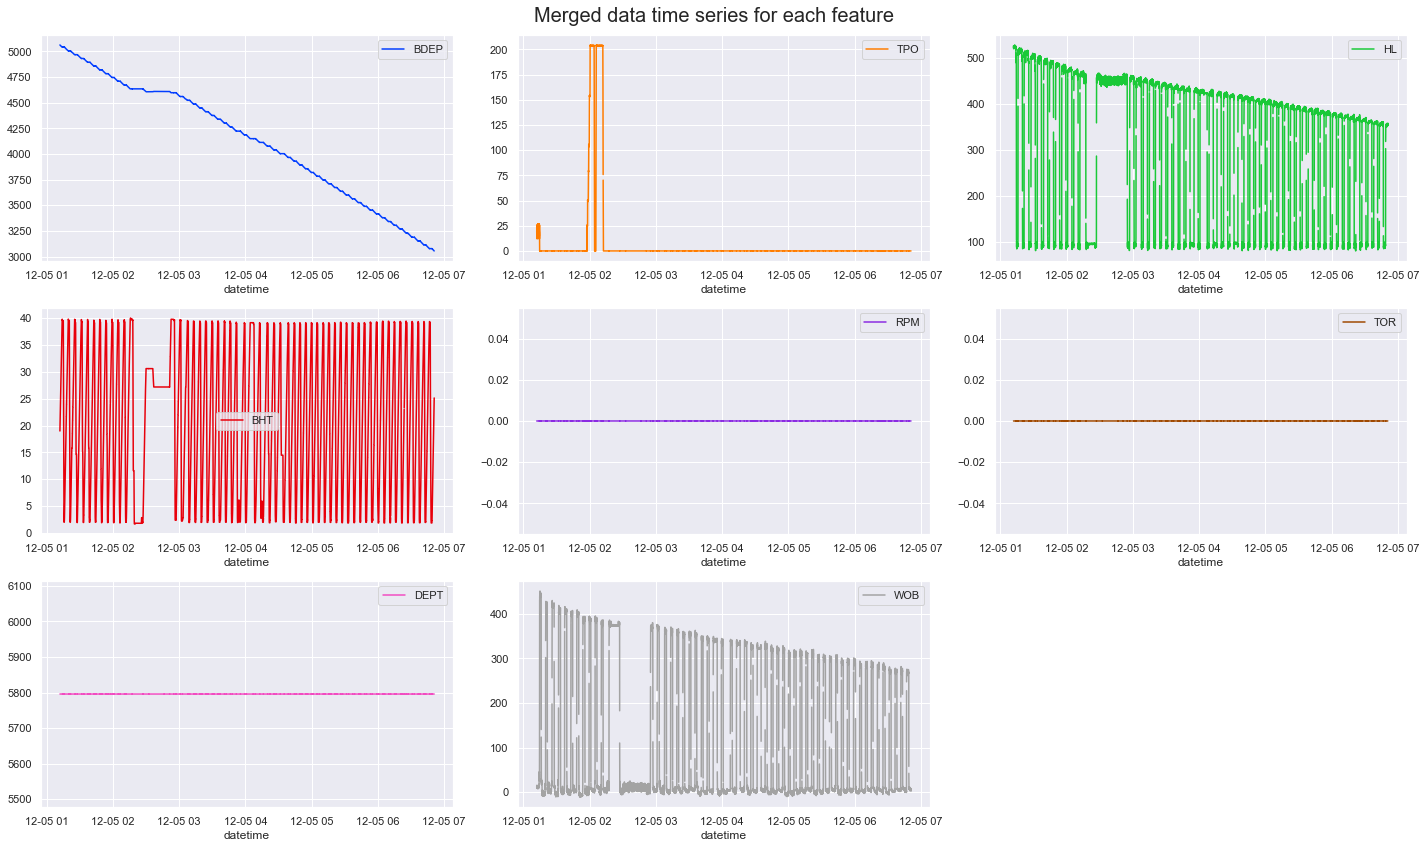

In [211]:
# Time series plot for each feature in the merged data frame
merged_df.plot(
    subplots=True, figsize=(20, 12),  layout=(3, 3), 
    sharex=False, sharey=False, 
    color=sns.color_palette("bright"),
)
plt.suptitle('Merged data time series for each feature', fontsize=20)
plt.tight_layout()
plt.show()

It's possible to notice possible outliers in some features, and others that doesn't show any relevant value, like `RPM`, `TOR` and `DEPT`.

In [212]:
print(f'{CYAN}RPM unique values: {WHITE} {merged_df["RPM"].unique()}')
print(f'{CYAN}TOR unique values: {WHITE} {merged_df["TOR"].unique()}')
print(f'{CYAN}DEPT unique values: {WHITE} {merged_df["DEPT"].unique()}')

RPM unique values:  [ 0. nan]
TOR unique values:  [ 0. nan]
DEPT unique values:  [5795.817      nan]


We can omit these features an plot again, with all information in a single plot.

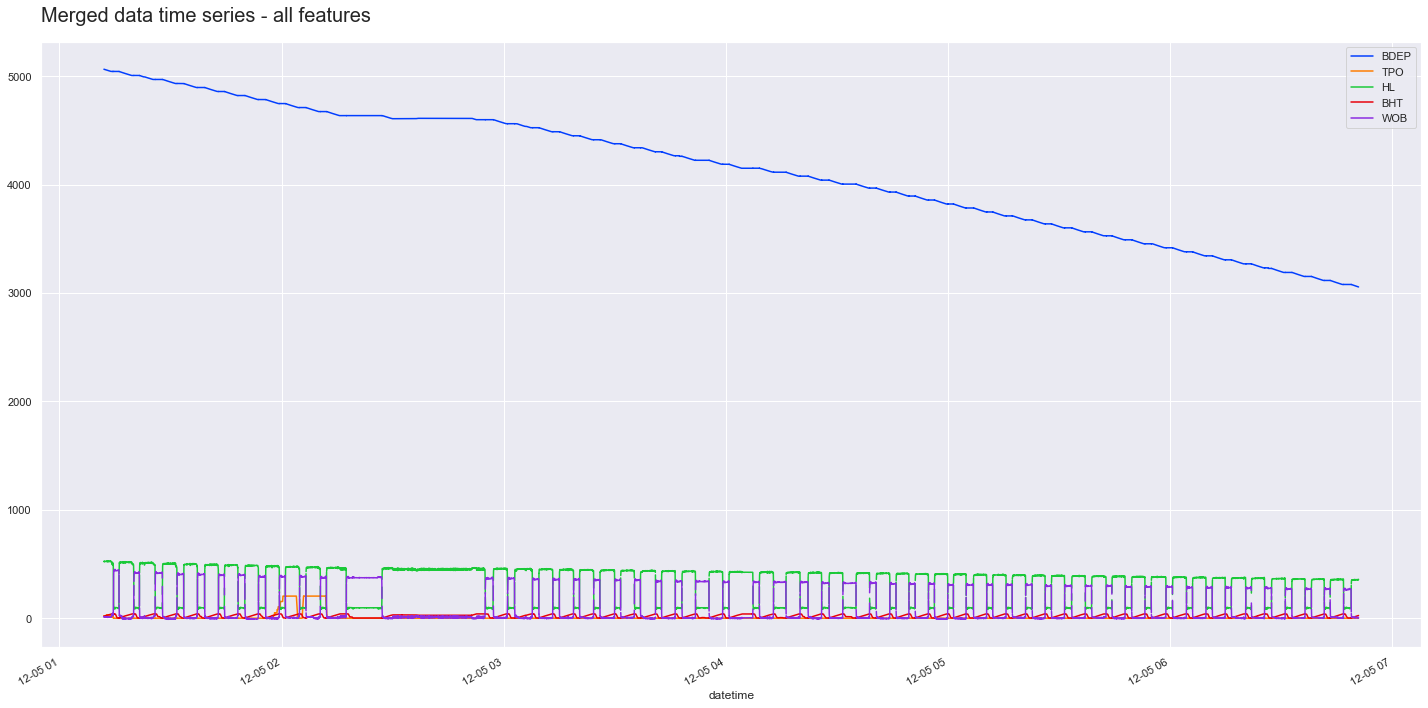

In [213]:
# Time series plot without RPM, TOR and DEPT features
merged_df.drop(columns=['RPM', 'TOR', 'DEPT']).plot(
    figsize=(20, 10),
    color=sns.color_palette("bright"),
)
plt.title('Merged data time series - all features', fontsize=20, pad=20, loc='left')
plt.tight_layout()
plt.show()

It's still difficul to grasp useful insights with the scale difference and the length of our data.
We can make some transformations just to help with that, like standardize values to recude the scale. 

In [219]:
# Standardize merged_df
# Create a tempoary copy of the data without 'RPM', 'TOR', 'DEPT' and 'Annotation'
_temp_df = merged_df.drop(columns=['RPM', 'TOR', 'DEPT', 'Annotation']).copy()
# Apply standardization
norm_df = (_temp_df - _temp_df.mean()) / _temp_df.std()
# Add back Annotation target
norm_df['Annotation'] = merged_df['Annotation']
# Dump memory
del _temp_df

norm_df.head()

,BDEP,TPO,HL,BHT,WOB,Annotation
datetime,,,,,,
2020-12-05 01:12:00.314,1.651959,0.354543,1.270321,-0.150659,-0.618637,off_slips
2020-12-05 01:12:00.822,1.651959,0.242849,1.274487,-0.144224,-0.622830,off_slips
2020-12-05 01:12:01.329,1.651648,0.324758,1.282630,-0.137041,-0.631087,off_slips
2020-12-05 01:12:01.838,1.651648,0.257741,1.286517,-0.130681,-0.635022,off_slips
2020-12-05 01:12:02.346,1.651328,0.302419,1.293046,-0.123348,-0.641667,off_slips


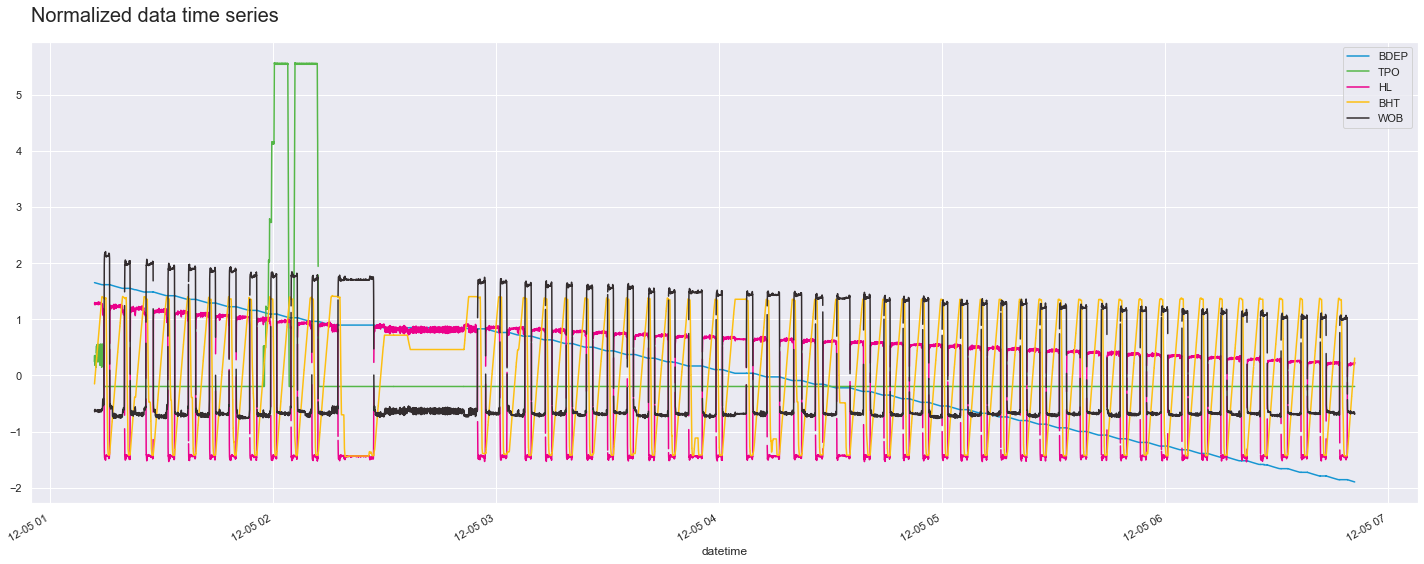

In [220]:
# Plot normalized data
norm_df.drop(columns='Annotation').plot(
    figsize=(20, 8),
    color=CATEGORICAL_GROUPS[norm_df.shape[1]],
)
plt.title('Normalized data time series', fontsize=20, pad=20, loc='left')
plt.tight_layout()
plt.show()

Some patterns, including seasonality and possible anomalies, seems more easly to notice. For now let's take a closer look in a period with the predominant season, and also add the `Annotation` value.  
> Note: the feature `TPO` will be omitted due to it's contanst value int the selected range of observation, and the standardization will be applied only in the subset, for a better visualization of the `BDEP` feature.

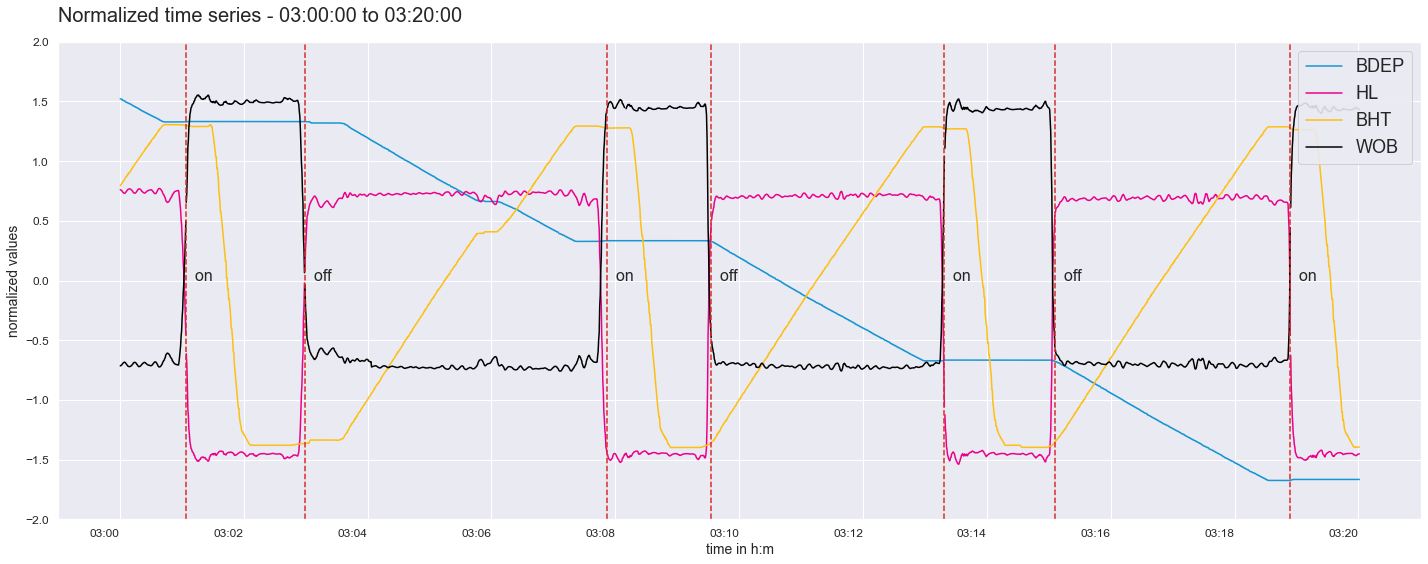

In [221]:
# Time series plot in a 20 minute window
# Note: in this plot the standardization is applied again just in the subset
# for a better visualization of the BDEP feature

_start_time = '2020-12-05 03:00:00'
_end_time = '2020-12-05 03:20:00'

# Temporary subset of data from 03:00 to 03:20
_temp_df = (
    merged_df
    .drop(columns=['RPM', 'TOR', 'DEPT','TPO', 'Annotation'])
    .loc[_start_time:_end_time].copy()
)
# Apply standardization on temp df
_temp_df = (_temp_df - _temp_df.mean()) / _temp_df.std()

# Plot time series
_temp_df.plot(
    figsize=(20, 8),
    color=['#1696d2', '#ec008b', '#fdbf11', '#000000'],
)
# Add verticals lines where Annotation is not null, with labels
_annot_index = (
    annot_df[annot_df['Annotation'].notnull()]
    .loc[_start_time:_end_time]
    .index
)
# Lines
[ plt.axvline(_annot, color='#DB2B27', linestyle='--') 
    for _annot in _annot_index ]
# Text
[ plt.text(
    _annot, 0, 
    '  ' + norm_df.loc[_annot, 'Annotation'].split('_')[0], 
    rotation=0, 
    fontsize=16
    ) for _annot in _annot_index 
]

plt.title(f'Normalized time series - {_start_time[-8:]} to {_end_time[-8:]}', fontsize=20, pad=20, loc='left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xlabel('time in h:m', fontsize=14)
plt.ylabel('normalized values', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-2, 2)
plt.legend(loc='upper right', fontsize=18, framealpha=0.9)
plt.tight_layout()
plt.show()

Very useful insights can be observed, which will be addressed later.

## Features/target correlation heatmap

To analyze the correlation of our features and target, both *Pearson* and *Spearman* methods will be applied.  

In summary, the Pearson correlation coefficient is used to measure the **strength and direction of a linear relationship between two continuous variables**, while the Spearman correlation coefficient is used to measure the **degree of monotonic relationship between two variables**, which may not be strictly linear.  

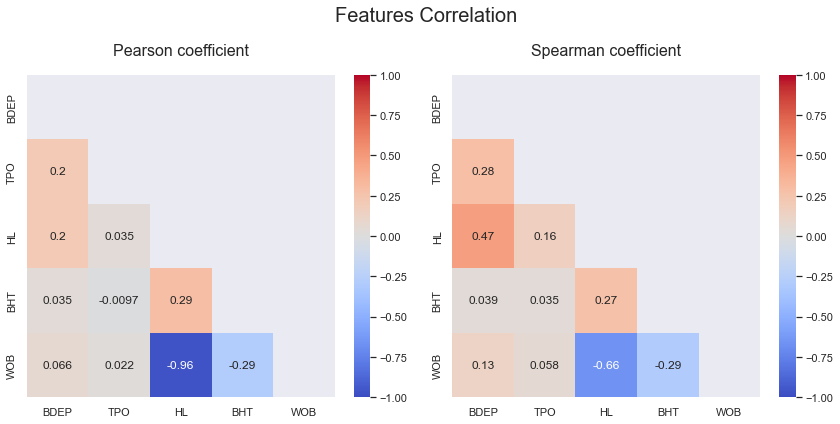

In [19]:
# Features correlation heatmap (Pearson and Spearman), hidding the upper triangle
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

_plot_data = merged_df.drop(columns=['RPM', 'TOR', 'DEPT']).corr(method='pearson')
sns.heatmap(
    _plot_data, 
    annot=True, 
    cmap='coolwarm', 
    mask=np.triu(np.ones_like(_plot_data, dtype=bool)),
    vmin=-1, vmax=1,
    ax=ax[0], 
)
ax[0].set_title('Pearson coefficient', size=16, pad=20)

_plot_data = merged_df.drop(columns=['RPM', 'TOR', 'DEPT']).corr(method='spearman')
sns.heatmap(
    _plot_data, 
    annot=True, 
    cmap='coolwarm', 
    mask=np.triu(np.ones_like(_plot_data, dtype=bool)),
    vmin=-1, vmax=1,
    ax=ax[1], 
    )
ax[1].set_title('Spearman coefficient', size=16, pad=20)
fig.suptitle('Features Correlation', size=20)
fig.tight_layout()
plt.show()

In [20]:
# Show the top three most relevant correlations for each method, Pearson and Spearman
print(f'{GREEN}Three most significant correlations{WHITE}')
for _method in ['pearson', 'spearman']:
    print(f'{CYAN}{_method.capitalize()}:{WHITE}')
    print(
        merged_df
        .drop(columns=['RPM', 'TOR', 'DEPT'])
        .corr(method=_method)
        .abs().unstack()
        .sort_values(ascending=False)
        .drop_duplicates().iloc[1:4]
        .round(3)
    )
    print()

Three most significant correlations
Pearson:
WOB  HL     0.962
BHT  HL     0.290
WOB  BHT    0.285
dtype: float64

Spearman:
WOB   HL     0.659
BDEP  HL     0.472
WOB   BHT    0.292
dtype: float64



> Note: these two higher correlations for each method are actually negative.

The strong pearson correlation for `WOB` an `HL` is expected, as the weight on bit should increase after it's released by the low workload in the hook.  

For the spearman correlation, we have a medium correlation between `HL` and `WOB`/`BDEP`, and a weak one for `WOB` and `BHT`.  

A monotonic relationship between two variables can be shortly described is a relationship where the variables either consistently increase or decrease together, but not necessarily at a constant rate. When the value it's negative, this increase/decrease is inverse. Exactly what we can observe in this correlation.  

As for the weak correlation on `WOB` and `BHT`, we can assume that when the block position is increasing, means the pipe is being removed, thus the weight on bit will decrease.

## Challenge scenario

For the seasonality aspect, we can notice the following behaviors:  

1. Interval where `Annotation` is **'on_slips'/'off_slips'**:
    - HL oscillates at lower values;
    - WOB oscillates at higher values;
    - BHT quickly starts to decrease;
    - BDEP doesn't change
2. Interval where `Annotation` is **'off_slips'/'on_slips'**:
    - HL oscillates at higher values;
    - WOB oscillates at lower values;
    - BHT quickly starts to increase;
    - BDEP slowly decrease  
  
With all this information we can assume the following situation is happening:  
  
This is a **Trip out** operation, were there is no drilling operation since the pipes are beeing removed. `BDEP`(bit depth in m) decreasing, `RPM` and `TOR` with no values, and `DEPT` with a constant value(meaning how far the drilling went), are indicators of this behavior.  
Thus, when the annotation flag is *on_slips*, hook load(`HL`) will operate in it's minimum value range, making the bit sustain more weight and increasing the value on `WOB`. Block position(`BHT`) will quickly drop when the pipe is beeing disconnected, and bit depth(`BDEP`) doesn't change.  
After the removal of slips, *off_slips* flag, hook load(`HL`) will immediately increase due to the pipes released weight, making `WOB` decrease. The hook is attached to an elevator, which is pulling the next pipe, making `BHT` increase and `BDEP` decrease.
When the whole pipe is out, slips are insert and the process is repeated.  

## Features analysis

### Analysis setup

In this section, we will look for each feature individually, and analyze the following aspects:  
- Features distribution
- STL decomposition
- Anomaly detection using residuals and K-means
- Stationary
- Autocorrelation
- Granger causality test

Some steps, such as decomposition, will need a *period* argument to use as a parameter for the number of observations in a seasonal cycle.  
As describe in the project, the time between slips connections tends to be around 1:30 minutes, or 90 seconds, and since each observation is outputed at 0.5 seconds, we should used the value of 180.  
However, when analyzing the data, the mean time where slips are *on* its 2 minutes, and 4 minutes for when it's *off*, thus the value for *period* will be (2*60 + 4*60) * 2 = 720.

In [22]:
# Calculating how many minutes the slips was in each state
temp_df = merged_df.copy()
# fill Annotation with 0 where "none"
temp_df['Annotation'] = temp_df['Annotation'].replace('none', np.nan)
old_vc = temp_df.Annotation.value_counts()
# fill Annotation ffill
temp_df['Annotation'] = temp_df['Annotation'].ffill()
# fill Annotation bfill
temp_df['Annotation'] = temp_df['Annotation'].bfill()
mean_slip_time = temp_df.Annotation.value_counts()/(120 * old_vc)
print(f'Mean time with {GREEN}off_slips{WHITE}: {mean_slip_time[0]:.2f} minutes')
print(f'Mean time with {GREEN}on_slips{WHITE}: {mean_slip_time[1]:.2f} minutes')

Mean time with off_slips: 4.22 minutes
Mean time with on_slips: 2.00 minutes


Missing values will be addressed later, but since it's such a small percentage of the dataset, they will be removed in order to perform statistical calculations.

In [23]:
print(f'{GREEN}Percentage of NaNs in each feature{WHITE}')
print((merged_df.isna().sum() / merged_df.shape[0]).round(6)*100)

Percentage of NaNs in each feature
BDEP          0.2673
TPO           0.2992
HL            0.2722
BHT           0.3041
RPM           0.3310
TOR           0.3090
DEPT          0.3212
WOB           0.3212
Annotation    0.0000
dtype: float64


In [24]:
# Set period value
PERIOD = 720
# Subset most important features
FEATURES =['BDEP', 'TPO', 'HL', 'BHT', 'WOB']
# Prepare raw data to analyze
df = merged_df.drop(columns='Annotation').dropna().copy()
print(f'{GREEN}Data frame shape:{WHITE}', df.shape)
df.head()

Data frame shape: (40647, 8)


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
datetime,,,,,,,,
2020-12-05 01:12:00.314,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38
2020-12-05 01:12:00.822,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73
2020-12-05 01:12:01.329,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45
2020-12-05 01:12:01.838,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84
2020-12-05 01:12:02.346,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81


#### Features distribution

Feature distribution refers to the pattern or shape of the distribution of values in a dataset for a particular variable. The distribution of a feature is important to understand the underlying characteristics of the data and can provide useful insights.  

In this step, we will analyse the distribution by plotting the boxplot next to the feature time series.  

In [90]:
# Function to plot a line plot and a box plot for a given feature
def line_box_plot(data:pd.Series) -> any:
    
    _feature_name = data.name

    # Set figure and axes
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [7, 3]})

    # Lineplot
    data.plot(ax=ax[0], color='#1696d2', linewidth=1)

    # Boxplot
    sns.boxplot(y=data, color='#fdbf11', ax=ax[1])

    # Plot style and labels
    fig.suptitle(f'{_feature_name} analysis', size=20, horizontalalignment='left', x=0.05)
    ax[0].set_title('Time series', size=16, pad=20, loc='left')
    ax[1].set_title('Boxplot distribution', size=16, pad=20, loc='left')
    ax[0].set_xlabel('time in h:m', fontsize=14)
    ax[0].tick_params(axis='x', labelrotation=0)
    ax[1].tick_params(axis='x', labelrotation=0)
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=40))
    fig.tight_layout()

    plt.show()

#### STL decomposition

STL decomposition stands for Season-Trend decomposition using LOESS(Locally estimated scatterplot smoothing).  
It is a time series method to seprate into three components: seasonal, trend and residuals.  
* **Seasonal component**: cyclic or seasonal fluctuations in the time series;  
* **Trend component**: captures the long-term trends;  
* **Residuals component**: contains the random or residual fluctuations not accounted by the others components.    
  
This step will be done using the `statsmodels` API.

In [79]:
from statsmodels.tsa.seasonal import STL

# Function to perform STL and plot the components
def stl_decomposition(
    data:pd.Series, 
    period:int,
    show_figure:bool=True,
    return_results:bool=True,
    ) -> any:

    _feature_name = data.name

    # Make STL decomposition
    if data.isna().any():
        # print warning
        print(f'{RED}Warning:{WHITE} {_feature_name} has NaN values, which will be dropped.')
        data = data.dropna()

    # Perform STL decomposition
    stl = STL(data, period=period).fit()
    results = pd.DataFrame({
        'Trend': stl.trend,
        'Seasonal': stl.seasonal,
        'Residual': stl.resid,
    })

    # Plot seasonal, trend and residual components
    if show_figure:
        fig, ax = plt.subplots(3, 1, figsize=(12,10), sharex=True)

        for i, _component in enumerate(results):
            results[_component].plot(
                ax=ax[i],
                color=CATEGORICAL_GROUPS[3][i],
                linewidth=1,
            )
            ax[i].set_title(f'{_component} component', size=16, pad=20, loc='left')
            ax[i].set_xlabel('')
            ax[i].set_ylabel(f'{_component}', size=14)
            ax[i].tick_params(axis='x', labelrotation=0)
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=40))

        # Main title
        fig.suptitle(
            f'{_feature_name} Season-Trend decomposition using LOESS', 
            size=20, horizontalalignment='left', x=0.05)

        # Plot figure
        fig.tight_layout()
        plt.show()
    
    # Return results
    if return_results:
        return results

#### Anomaly detection

After computing the components from STL, we can use the residuals to identify possible outliers.  
Whenever the residuals shows extremes values, it will be classified as an anomaly. For this we calculate the lower and upper boundaries with the mean, standard deviation and a threshold to set the limits.

In [108]:
# Function to detect outliers with iqr using the reisidual component
def detect_outliers(
    data:pd.Series, 
    residuals,
    threshold:float=3,
    return_outliers:bool=True
    ) -> any:

    # Get feature name
    _feature_name = data.name
    
    # Calculate mean and std of the residuals
    _mean = residuals.mean()
    _std = residuals.std()

    # Calculate upper and lower limit
    _upper_bound = _mean + threshold * _std
    _lower_bound = _mean - threshold * _std

    # Detect outliers
    _outliers = residuals[(residuals > _upper_bound) | (residuals < _lower_bound)].index

    if _outliers.shape[0]==0:
        print('No outliers detected in residuals component.')
        return None

    else:
        # Plot outliers
        plt.figure(figsize=(12, 4))
        # Time series
        data.plot(color='#1696d2', linewidth=1)
        # Outliers points
        plt.scatter(x=_outliers, y=data[_outliers],
            color='#DB2B27', marker='x', s=100)
        # Number of outliers
        plt.text(0.925, 0.925, f'{_outliers.shape[0]} outliers',
            horizontalalignment='right',
            verticalalignment='top',
            transform=plt.gca().transAxes,
            fontdict={'size': 14},
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
        )
        # Styling and labels
        plt.suptitle(f'{_feature_name} outliers detection', size=20, horizontalalignment='left', x=0.05)
        plt.title(f'threshold = {threshold}', size=14, pad=20, loc='left')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=40))
        plt.xlabel('time in h:m', size=14)
        plt.tick_params(axis='x', labelrotation=0)
        plt.tight_layout()
        plt.show()

        if return_outliers:
            return _outliers

#### Stationarity

Checking if a time series is stationary is important because it allows for the use of various statistical techniques that rely on the assumption of stationarity.   
When a time series is not stationary, the statistical properties of the data change over time, which can make it difficult to model and forecast accurately.  

One way to accomplish that is by perfoming an *[Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)*.  

In ADF test, the null hypothesis is that the time series data is non-stationary, therefore if our *p-value* is lower than the significance level (usually 0.05), we reject the null hypothesis and conclude that the data is stationary.
> p-value > 0.05: data is non-stationary  
> p-value < 0.05: data is stationary  

In [81]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(data:pd.Series, return_results:bool=False) -> any:
    _feature_name = data.name

    # Perform ADF test
    result = adfuller(data.dropna())

    # Print results
    print(f'{GREEN}p-value for {_feature_name}{WHITE}: {result[1]}')
    print(f'{CYAN}Reject H₀{WHITE}: {"True, data is stationary" if result[1] < 0.05 else "False, data is non-stationary"}')

    # Return results
    if return_results:
        return result

#### Autocorrelation

Autocorrelation is a statistical property of time series data that measures the linear relationship between a time series and a lagged version of itself. It can measures how similar the values of a time series are at different time lags.  

For instance, if some feature has an high autocorrelation, it means that there is a strong relationship between the original value and the lag, suggesting that the time series may be affected by a seaonal pattern or some kind of trend.  

We can compute autocorrelation with the `statsmodels` API.

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Function to compute autocorrelation and partial autocorrelation
def compute_acf_pacf(data:pd.Series, period:int):

    _feature_name = data.name
    data = data.dropna()

    # Compute autocorrelation
    _auto_corr = data.autocorr(lag=period) > 0.05
    print(
        f'{CYAN}Autocorrelation for lag = {period}: {WHITE}',
        f'{_auto_corr:.4f}',
        f'{CYAN}\nData is autocorrelated?\t\t{WHITE}'
        'Yes' if _auto_corr > 0.05 else 'No'
    )
    # Plot autocorrelation
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    plot_acf(data, lags=period, ax=ax[0], title='')
    plot_pacf(data, method='ywm', lags=period, ax=ax[1], title='')
    fig.suptitle(f'{_feature_name} ACF/PACF', size=20, horizontalalignment='left', x=0.05)
    ax[0].set_title('Autocorrelation function', size=16, pad=20, loc='left')
    ax[1].set_title('Partial autocorrelation function', size=16, pad=20, loc='left')
    [ax[i].set_ylim(-1.1, 1.1) for i in range(2)]
    plt.tight_layout()
    plt.show()

#### Granger causality test

The Granger causality test is a statistical hypothesis test used to determine whether one time series is useful in forecasting another time series.  
It is important to note that this test only provides evidence for a causal relationship between two time series, and does not necessarily prove causality.

In [31]:
from statsmodels.tsa.stattools import grangercausalitytests

# Function to perform Granger causality test
def granger_test(data:pd.DataFrame, verbose:bool=True, return_results:bool=False) -> any:

    # Extract feature names
    _feature_name = data.columns[0]
    _feature_name2 = data.columns[1]

    # Calculate test
    result = grangercausalitytests(
        data.dropna(),
        maxlag=10,
        verbose=False,
    )

    # Print results
    if verbose:
        print(f'{GREEN}p-value for {_feature_name} -> {_feature_name2}{WHITE}: {result[1][0]["ssr_ftest"][1]}')
        print(f'{CYAN}Reject H₀{WHITE}: ', end='')
        _h0 = f'False, {_feature_name} is NOT useful to forecast {_feature_name2}'
        _h1 = f'True, {_feature_name} is useful to forecast {_feature_name2}'
        print(f'{_h1}' if result[1][0]["ssr_ftest"][1] < 0.05 else f'{_h0}')

    # Return results
    if return_results:
        return result

#### Unsupervised learning

Finally, unsupervised learning for all the most important features with K-means clustering may reveal additional patterns and insights.   
  
First we need to search for the optimal number of clusters, using the elbow method and the silhouette score, and them plot the results to visualize clusters.  

This step will be performed with the `sklearn` API.

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters
def optimal_k(data:pd.DataFrame, k_range=range(2,8), kmeans_kwargs=None) -> any:

    # Clustering settings
    if not kmeans_kwargs:
        kmeans_kwargs = {
            "init": "random", 
            "n_init": 10, 
            "max_iter": 300, 
            "random_state": 42
        }
    inertia_list = []
    ss_list = []

    # Loop through k clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        ss_list.append(silhouette_score(data, kmeans.labels_))
        inertia_list.append(kmeans.inertia_)
    
    return inertia_list, ss_list

# Plot the elbow curve and silhouette score
def plot_elbow_curve(inertia_list:list, ss_list:list) -> any:

    # Create figure
    _, ax = plt.subplots(1, 2, figsize=(10, 4))

    n_clusters = range(2, len(inertia_list)+2)

    # Plot elbow curve
    ax[0].plot(n_clusters, inertia_list, marker='o', color='#1696d2')
    ax[0].set_title('Elbow curve', size=16, pad=20, loc='left')
    ax[0].set_xlabel('Number of clusters', size=14)
    ax[0].set_ylabel('Inertia', size=14)

    # Plot silhouette score
    ax[1].plot(n_clusters, ss_list, marker='o', color='#fdbf11')
    ax[1].set_title('Silhouette score', size=16, pad=20, loc='left')
    ax[1].set_xlabel('Number of clusters', size=14)
    ax[1].set_ylabel('Silhouette score', size=14)

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot clusters
def plot_kmeans_clusters(data:pd.DataFrame, kmeans:KMeans):
    plt.figure(figsize=(12, 6))
    plt.scatter(
        x=data.index,
        y=data,
        c=kmeans.labels_, cmap='tab10')
    plt.suptitle('TPO with K-Means clusters', size=20, horizontalalignment='left', x=0.05)
    plt.title(f'Number of clusters: {kmeans.n_clusters}', size=14, pad=20, loc='left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=40))
    plt.xlabel('time in h:m:s', size=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tight_layout()
    plt.show()

### BDEP

Bit depth in meters.

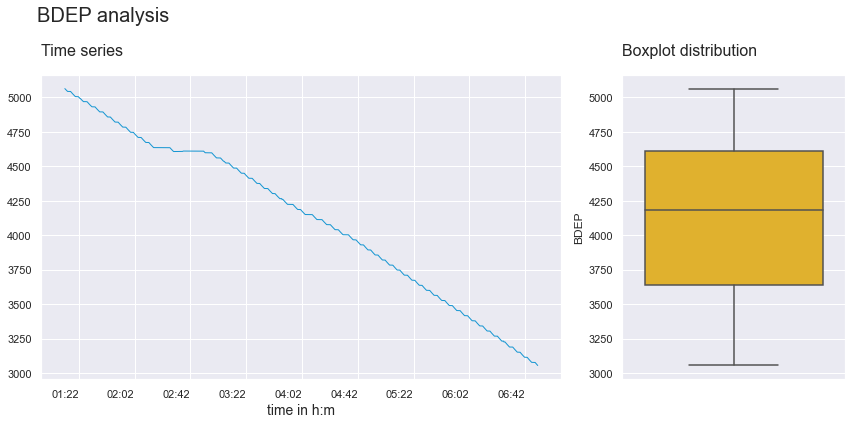

In [32]:
# BDEP distribution
line_box_plot(df['BDEP'])

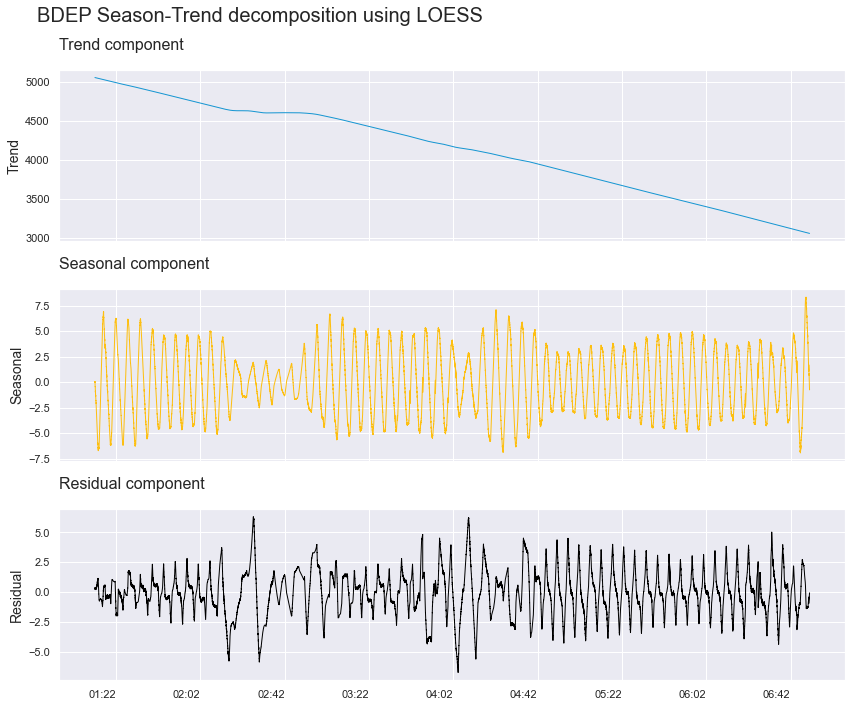

In [33]:
# Perform STL decomposition for BDEP
bdep_results = stl_decomposition(df['BDEP'], period=PERIOD)

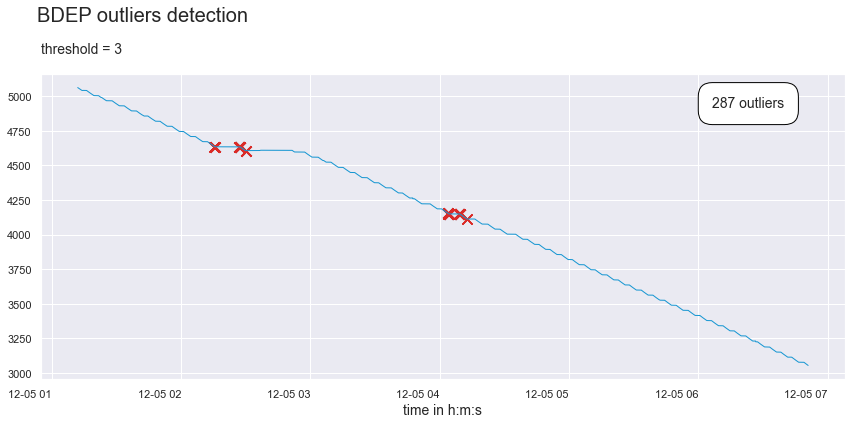

In [34]:
# Detect outliers for BDEP
bdep_outliers = detect_outliers(df['BDEP'], bdep_results['Residual'])

In [35]:
# Check stationarity of BDEP
adf_test(df['BDEP'])

p-value for BDEP: 0.9979041998702077
Reject H₀: False, data is non-stationary


Autocorrelation for lag = 240:  1.0000 
Data is autocorrelated?		Yes


c:\Users\joaob\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


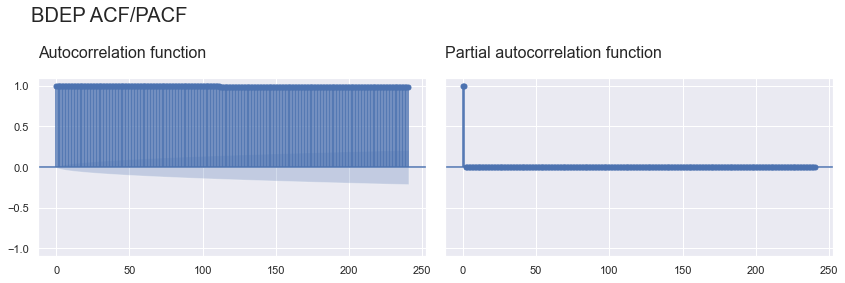

In [36]:
# Check autocorrelation of BDEP
compute_acf_pacf(df['BDEP'])

In [37]:
# Check Granger causality between BDEP and all features
for feature in df[FEATURES].drop(columns='BDEP').columns:
    granger_test(df[['BDEP', feature]])

p-value for BDEP -> TPO: 2.1896007539940932e-08
Reject H₀: True, BDEP is useful to forecast TPO
p-value for BDEP -> HL: 0.0
Reject H₀: True, BDEP is useful to forecast HL
p-value for BDEP -> BHT: 0.007301554172113497
Reject H₀: True, BDEP is useful to forecast BHT
p-value for BDEP -> WOB: 0.0
Reject H₀: True, BDEP is useful to forecast WOB


### TPO

Fluid flow in *gpm* (gallons per minute).

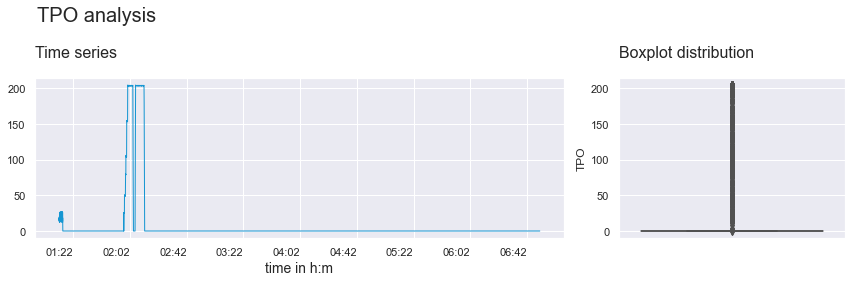

In [91]:
# TPO distribution
line_box_plot(df['TPO'])

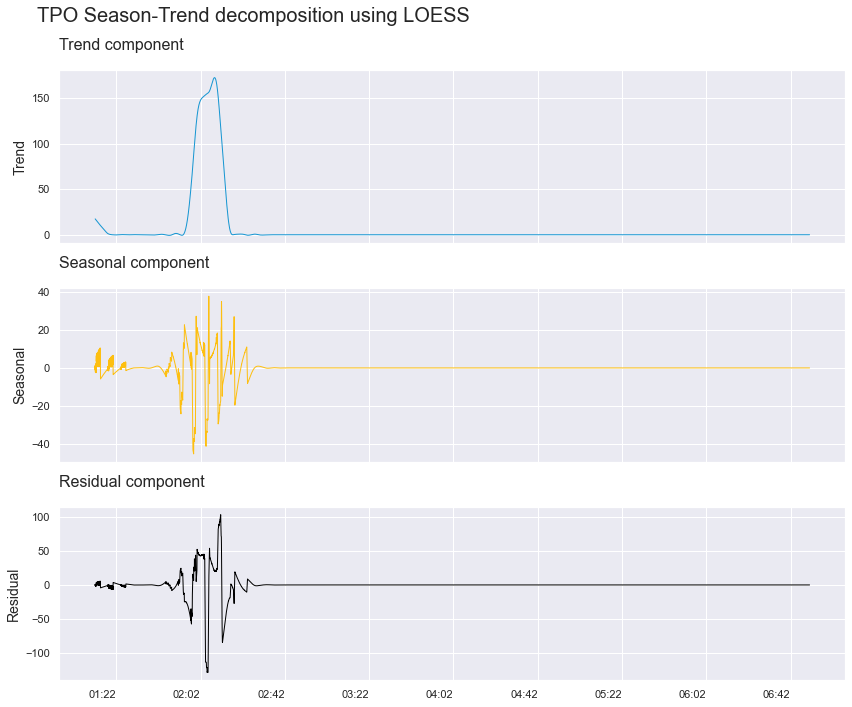

In [39]:
# STL decomposition for TPO
tpo_results = stl_decomposition(df['TPO'], period=PERIOD)

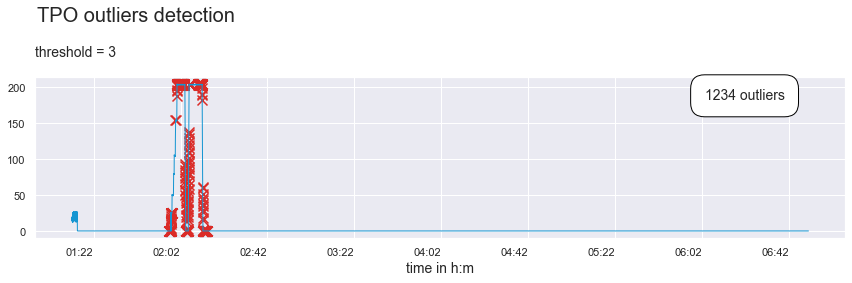

In [159]:
# Detect outliers for TPO
tpo_outliers = detect_outliers(df['TPO'], tpo_results['Residual'])

In [41]:
# Check stationarity of TPO
adf_test(df['TPO'])

p-value for TPO: 1.4159533155729775e-05
Reject H₀: True, data is stationary


Autocorrelation for lag = 720:  1.0000 
Data is autocorrelated?		Yes


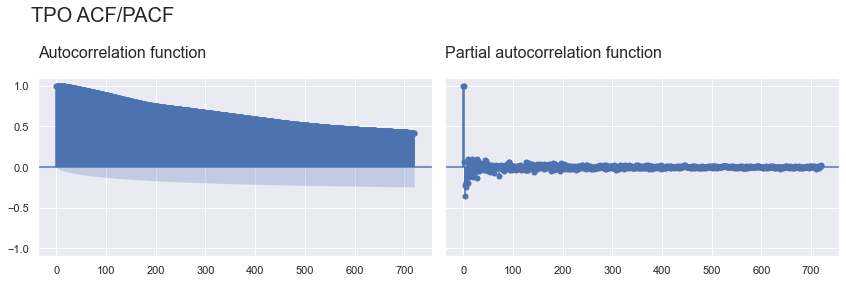

In [85]:
# Check autocorrelation of TPO
compute_acf_pacf(df['TPO'], period=PERIOD)

In [43]:
# Check Granger causality between TPO and all features
for feature in df[FEATURES].drop(columns='TPO').columns:
    granger_test(df[['TPO', feature]])

p-value for TPO -> BDEP: 0.7716277466738488
Reject H₀: False, TPO is NOT useful to forecast BDEP
p-value for TPO -> HL: 2.626854616903159e-05
Reject H₀: True, TPO is useful to forecast HL
p-value for TPO -> BHT: 0.8414318264156562
Reject H₀: False, TPO is NOT useful to forecast BHT
p-value for TPO -> WOB: 1.3462285892413177e-05
Reject H₀: True, TPO is useful to forecast WOB


### HL

Hook load in *klbf*.

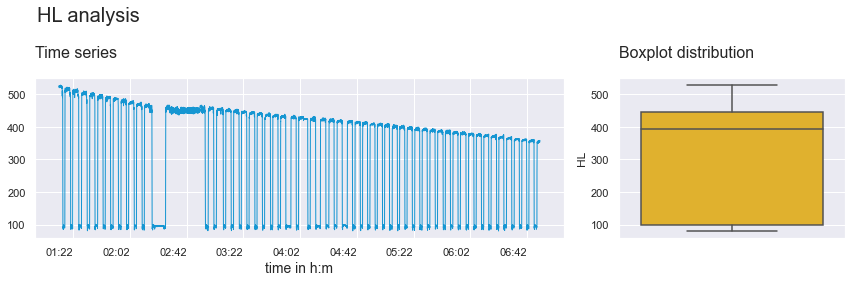

In [92]:
# HL distribution
line_box_plot(df['HL'])

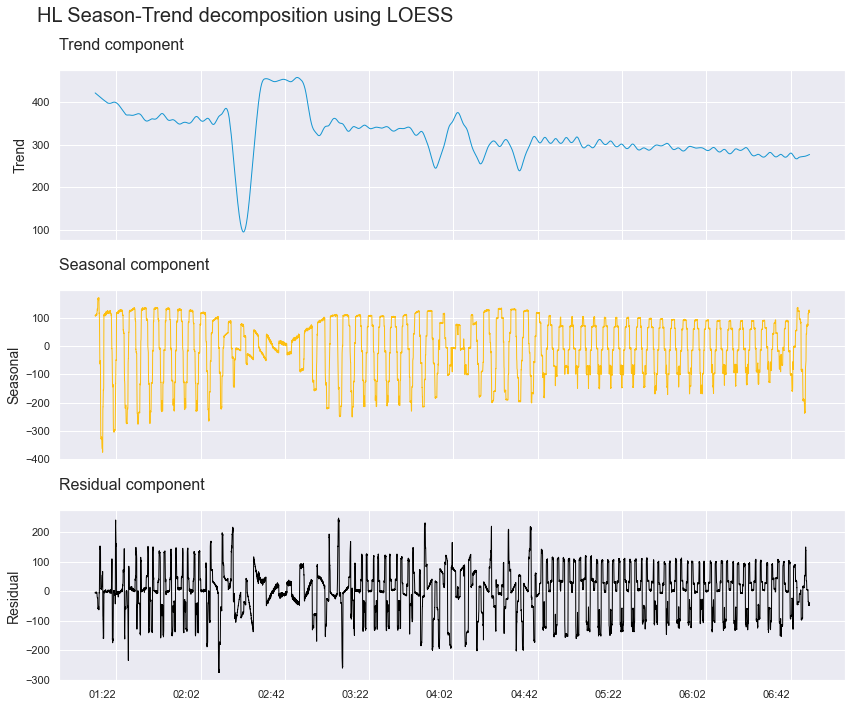

In [45]:
# STL decomposition for HL
hl_results = stl_decomposition(df['HL'], period=PERIOD)

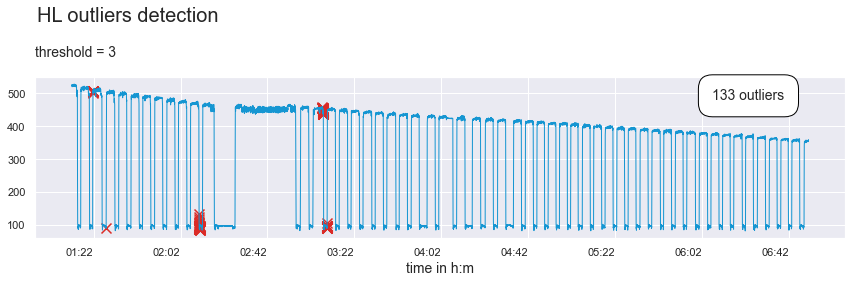

In [158]:
# Detect outliers for HL
hl_outliers = detect_outliers(df['HL'], hl_results['Residual'])

In [86]:
# Check stationarity of HL
adf_test(df['HL'])

p-value for HL: 3.7961498742452274e-20
Reject H₀: True, data is stationary


Autocorrelation for lag = 720:  1.0000 
Data is autocorrelated?		Yes


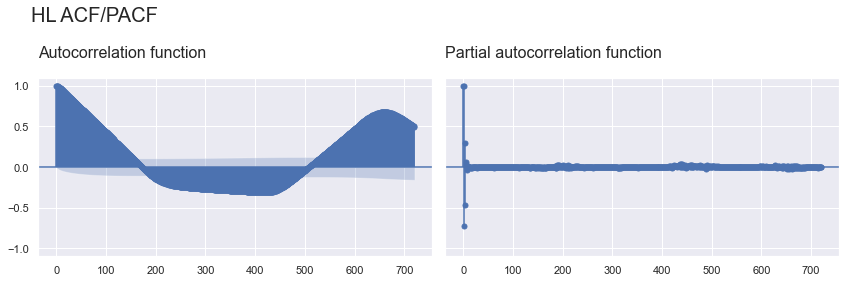

In [88]:
# Check autocorrelation of HL
compute_acf_pacf(df['HL'], period=PERIOD)

In [49]:
# Check Granger causality between HL and all features
for feature in df[FEATURES].drop(columns='HL').columns:
    granger_test(df[['HL', feature]])

p-value for HL -> BDEP: 0.44736568757474815
Reject H₀: False, HL is NOT useful to forecast BDEP
p-value for HL -> TPO: 0.05691043878818542
Reject H₀: False, HL is NOT useful to forecast TPO
p-value for HL -> BHT: 0.0
Reject H₀: True, HL is useful to forecast BHT
p-value for HL -> WOB: 0.48149660424029095
Reject H₀: False, HL is NOT useful to forecast WOB


### BHT

Block position in meters.

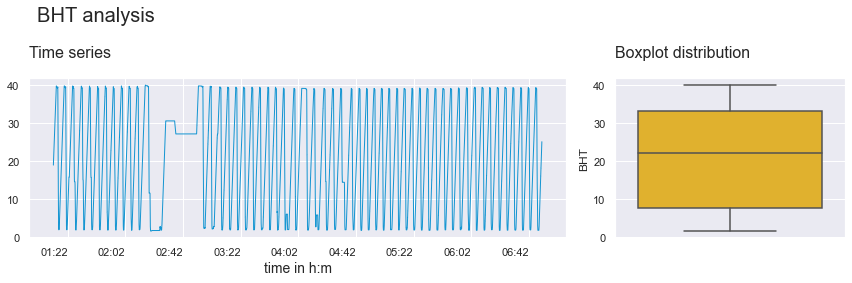

In [96]:
# BHT distribution
line_box_plot(df['BHT'])

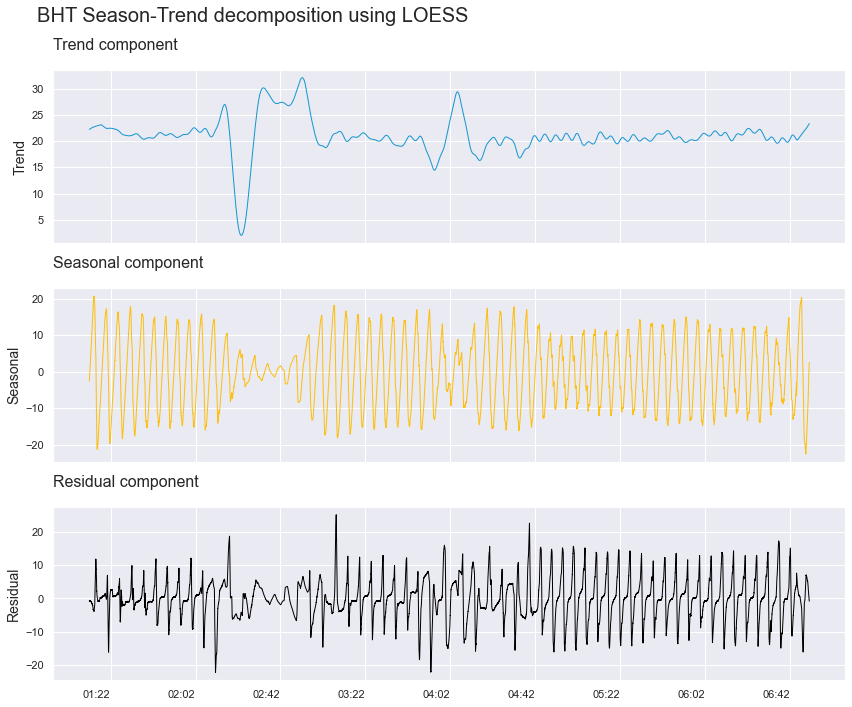

In [51]:
# STL decomposition for BHT
bht_results = stl_decomposition(df['BHT'], period=PERIOD)

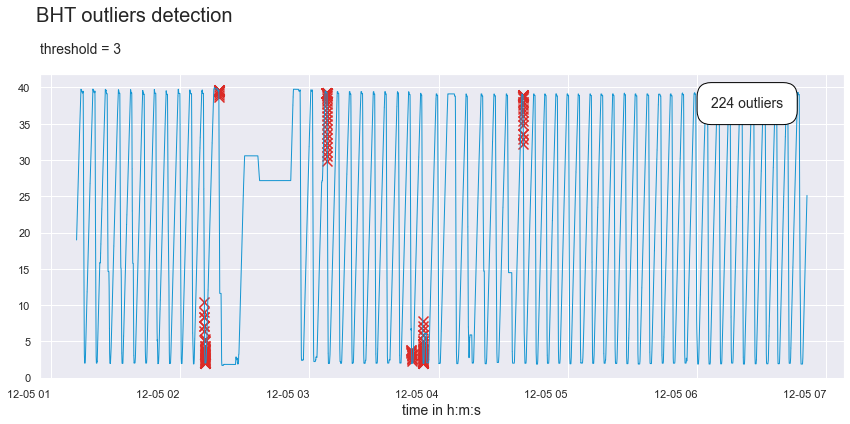

In [52]:
# Detect outliers for BHT
bht_outliers = detect_outliers(df['BHT'], bht_results['Residual'])

In [53]:
# Check stationarity of BHT
adf_test(df['BHT'])

p-value for BHT: 1.3568741971210378e-25
Reject H₀: True, data is stationary


Autocorrelation for lag = 720:  1.0000 
Data is autocorrelated?		Yes


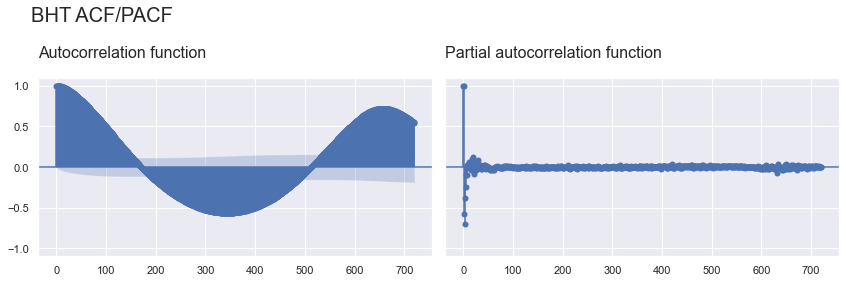

In [100]:
# Check autocorrelation of BHT
compute_acf_pacf(df['BHT'], period=PERIOD)

In [101]:
# Check Granger causality between BHT and all features
for feature in df[FEATURES].drop(columns='BHT').columns:
    granger_test(df[['BHT', feature]])

p-value for BHT -> BDEP: 0.9402784269813367
Reject H₀: False, BHT is NOT useful to forecast BDEP
p-value for BHT -> TPO: 0.9123475074432907
Reject H₀: False, BHT is NOT useful to forecast TPO
p-value for BHT -> HL: 0.0
Reject H₀: True, BHT is useful to forecast HL
p-value for BHT -> WOB: 0.0
Reject H₀: True, BHT is useful to forecast WOB


### RPM, TOR, DEPT

Rotart speed in *rpm*, toque in *klbf-tf*, hole depth in meters.

In [56]:
display(df[['RPM', 'TOR', 'DEPT']].describe())
for feature in df[['RPM', 'TOR', 'DEPT']].columns:
    print(f'{feature} unique values: {df[feature].unique()}')

,RPM,TOR,DEPT
count,40647.0,40647.0,4.064700e+04
mean,0.0,0.0,5.795817e+03
std,0.0,0.0,1.537974e-09
min,0.0,0.0,5.795817e+03
25%,0.0,0.0,5.795817e+03
50%,0.0,0.0,5.795817e+03
75%,0.0,0.0,5.795817e+03
max,0.0,0.0,5.795817e+03


RPM unique values: [0.]
TOR unique values: [0.]
DEPT unique values: [5795.817]


Since all this features have constant values, they will be dropped from the analysis.

### WOB

Weight on bit in *klbf*.

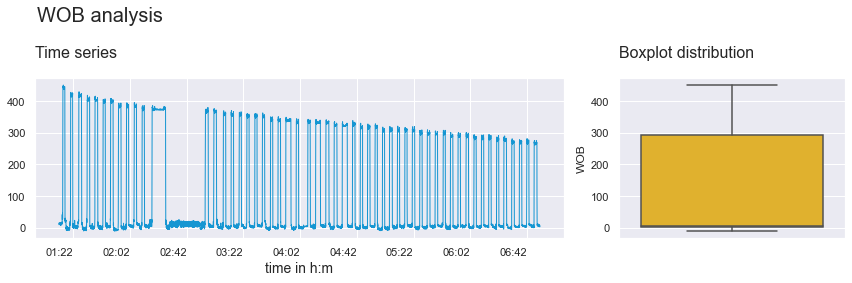

In [102]:
# WOB distribution
line_box_plot(df['WOB'])

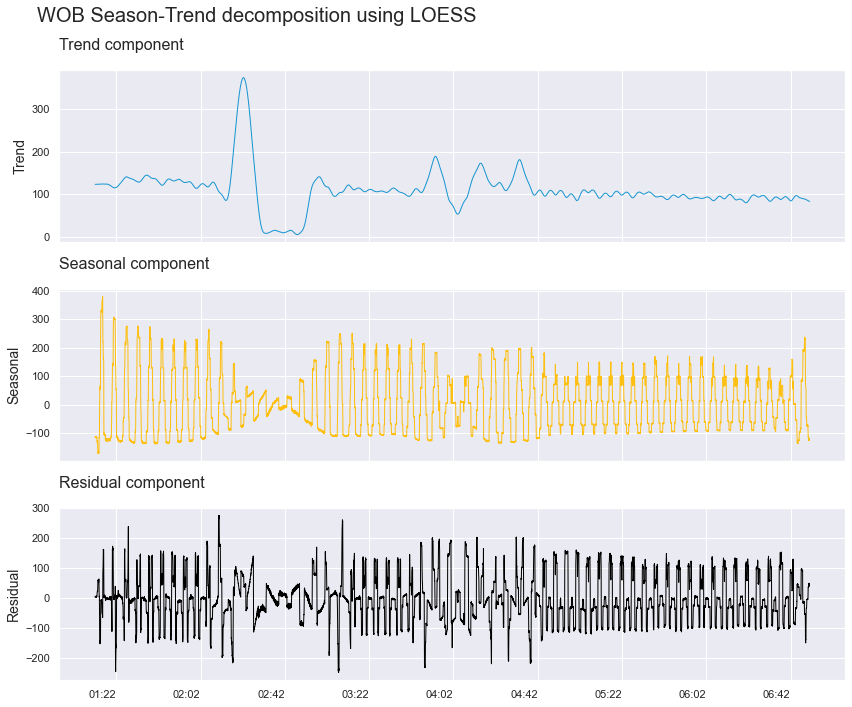

In [103]:
# STL decomposition for WOB
wob_results = stl_decomposition(df['WOB'], period=PERIOD)

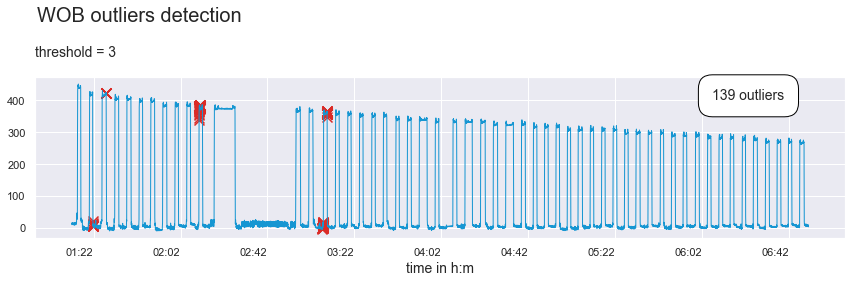

In [109]:
# Detect outliers for WOB
wob_outliers = detect_outliers(df['WOB'], wob_results['Residual'])

In [105]:
# Check stationarity of WOB
adf_test(df['WOB'])

p-value for WOB: 1.7701366159339087e-20
Reject H₀: True, data is stationary


Autocorrelation for lag = 720:  1.0000 
Data is autocorrelated?		Yes


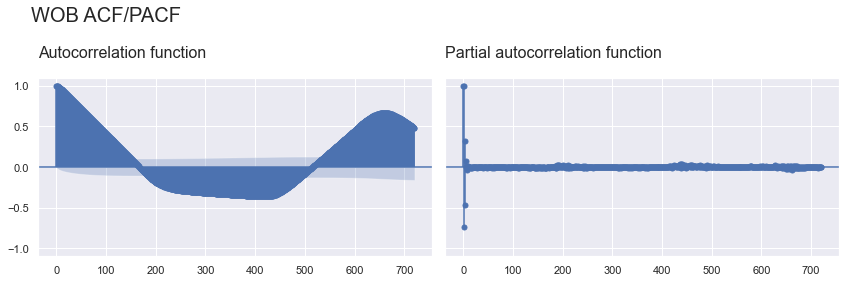

In [106]:
# Check autocorrelation of WOB
compute_acf_pacf(df['WOB'], period=PERIOD)

In [62]:
# Check Granger causality between WOB and all features
for feature in df[FEATURES].drop(columns='WOB').columns:
    granger_test(df[['WOB', feature]])

p-value for WOB -> BDEP: 0.8116985729658371
Reject H₀: False, WOB is NOT useful to forecast BDEP
p-value for WOB -> TPO: 0.08891508745862853
Reject H₀: False, WOB is NOT useful to forecast TPO
p-value for WOB -> HL: 0.7813964164566103
Reject H₀: False, WOB is NOT useful to forecast HL
p-value for WOB -> BHT: 0.0
Reject H₀: True, WOB is useful to forecast BHT


### K-means Clustering

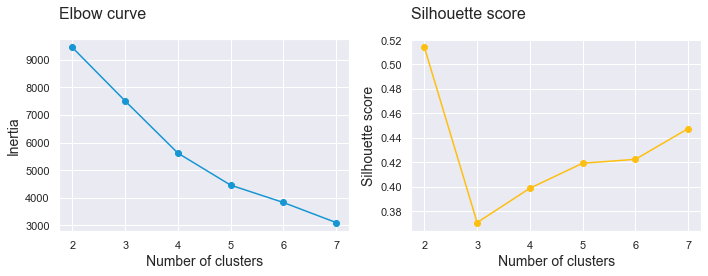

In [67]:
# Scale features before clustering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[FEATURES]), columns=FEATURES)

# Find optimal number of clusters
inertia_list, ss_list = optimal_k(df_scaled)

# Plot elbow curve and silhouette score
plot_elbow_curve(inertia_list, ss_list)

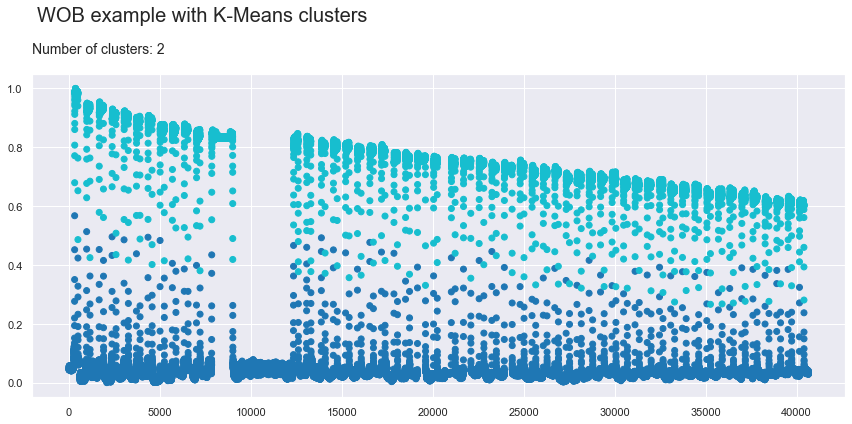

In [133]:
# Define K based on elbow curve and silhouette score
K = 2

# Perform K-means clustering
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=42)
kmeans.fit(df_scaled)

# Plot clusters
#df_scaled scatter plot of clusters
plt.figure(figsize=(12, 6))
plt.scatter(
    x=df_scaled.index,
    y=df_scaled['WOB'],
    c=kmeans.labels_, cmap='tab10')
plt.suptitle('WOB example with K-Means clusters', size=20, horizontalalignment='left', x=0.05)
plt.title(f'Number of clusters: {kmeans.n_clusters}', size=14, pad=20, loc='left')
plt.tight_layout()
plt.show()

### Summary

* `BDEP`: bit depth in meters have a decreasing trend over time, with some outliers detected in the period where the values are more constant. tatistical useful in forecasting all features. This is the only non-stationary feature.  
* `TPO`: high numbers of outliers and low values make thi feaure less important. Even when it has more activity, it has no direct impact on the seasonality. However, if this higher value is associated with some operational problem, it may have some relationship, since the next period of *on_slips* took more than the average 2 minutes, and after that there was a long period in *off_slips*, which may indicate some maintence to solve the problem.    
* `HL`: hook load is highly correlated with WOB. There is some interisting outliers occuring togheter with TPO, a few moments before the long pause in *off_slips*.  
* `BHT`: statistical significant to forecast HL and WOB, with some outliers also present in the moments before the mentioned event. During the long pause, the block position value is increasing, but suddenly decrease and later go back up again. This also may indicate some problem in the operation, as if the pipe felt for a short period of time. 
* `WOB`: weight on bit behaves very likely HL, as it were complete opposites.  
* `RPM`, `TOR`, `DEPT`: will be dropped since has constant values.

## Missing data

In [168]:
# Missing vaues summary
print(f'{CYAN}Missing values summary:{WHITE}')
data_df.stb.missing(style=True)

Missing values summary:


,missing,total,percent
RPM,26,"40,673",0.06%
DEPT,22,"40,673",0.05%
WOB,22,"40,673",0.05%
TOR,17,"40,673",0.04%
BHT,15,"40,673",0.04%
TPO,13,"40,673",0.03%
HL,2,"40,673",0.00%
BDEP,0,"40,673",0.00%


In [169]:
# Show rows with missing values
data_df[data_df.isna().any(axis=1)][data_df.columns[data_df.isna().any()].tolist()]

,TPO,HL,BHT,RPM,TOR,DEPT,WOB
datetime,,,,,,,
2020-12-05 01:36:29.376,0.0,497.159987,34.435,NaN,0.0,5795.817,2.66
2020-12-05 01:36:29.884,0.0,497.727987,34.435,NaN,0.0,5795.817,2.10
2020-12-05 01:57:39.368,0.0,483.163987,NaN,NaN,NaN,NaN,NaN
2020-12-05 01:57:39.880,0.0,482.213988,NaN,NaN,NaN,NaN,NaN
2020-12-05 02:11:49.107,NaN,93.847998,NaN,NaN,NaN,NaN,NaN
2020-12-05 02:11:49.428,NaN,93.685998,NaN,NaN,NaN,NaN,NaN
2020-12-05 02:11:49.432,NaN,93.563998,NaN,NaN,NaN,NaN,NaN
2020-12-05 02:11:49.436,NaN,94.417998,NaN,NaN,NaN,NaN,NaN
2020-12-05 02:11:49.843,NaN,94.595998,NaN,NaN,NaN,NaN,NaN


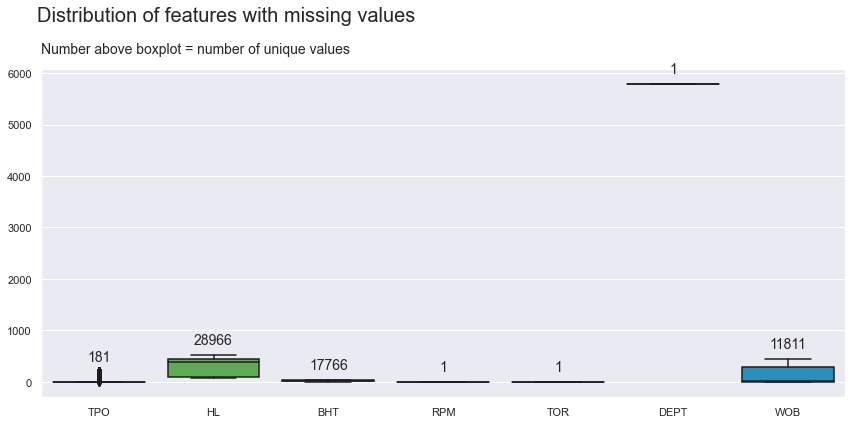

In [195]:
# Boxplot of features with missing values
_data = data_df[data_df.columns[data_df.isna().any()].tolist()]
plt.figure(figsize=(12, 6))
sns.boxplot(data=_data, palette=CATEGORICAL_GROUPS[6 if _data.shape[1] > 6 else _data.shape[1]])
# Plot text with number of unique values above each boxplot
for i, col in enumerate(_data.columns):
    plt.text(i, _data[col].max() + 200, f'{_data[col].nunique()}', ha='center', size=14)

plt.suptitle('Distribution of features with missing values', size=20, horizontalalignment='left', x=0.05)
plt.title('Number above boxplot = number of unique values', size=14, pad=15, loc='left')
plt.tight_layout()
plt.show()

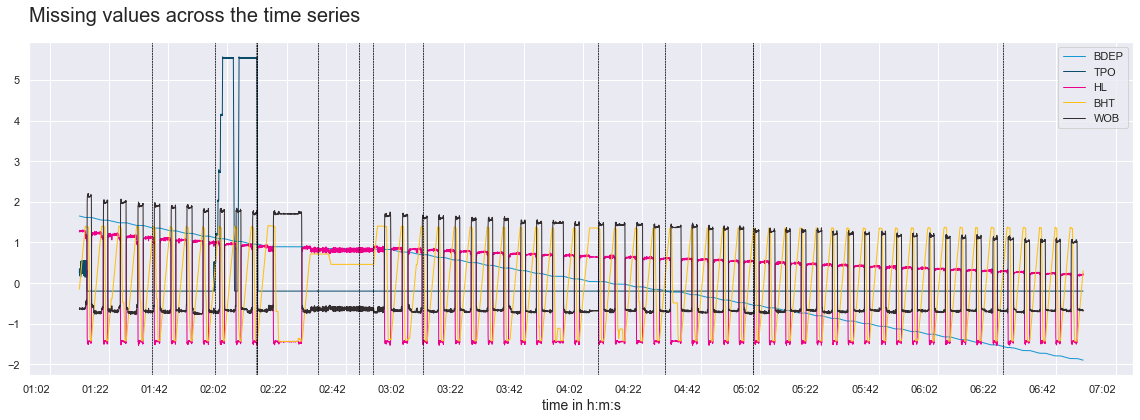

In [184]:
# Plot time series with missing values as vertical lines
fig, ax = plt.subplots(figsize=(16, 6))
_data = data_df.drop(columns=['RPM', 'TOR', 'DEPT']).copy()
# standardize data
_data = (_data - _data.mean()) / _data.std()
# plot data
_data.plot(color=CATEGORICAL_GROUPS[5], linewidth=1, ax=ax)
# add vertical lines for missing values
for i in data_df[data_df['RPM'].isna()].index:
    plt.axvline(x=i, color='black', linewidth=0.5, linestyle='--')
plt.title('Missing values across the time series', size=20, pad=20, loc='left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))
plt.xlabel('time in h:m:s', size=14)
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()

### Nullity correlation

Heatmap nullity correlation ranges from:
* -1 : if one variable appears the other definitely does not;
* 0 : variables appearing or not appearing have no effect on one another;  
* 1 : if one variable appears the other definitely also does.

*Algorithm*
```
df = df.iloc[:, [i for i, n in enumerate(np.var(df.isnull(), axis='rows')) if n > 0]]
corr_mat = df.isnull().corr()
```

Dendrogram uses a hierarchical clustering algorithm to bin variables against one another by their nullity correlation.  
The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.  

*Algorithm*
```
from scipy.cluster import hierarchy

x = np.transpose(df.isnull().astype(int).values)
z = hierarchy.linkage(x, method)
```

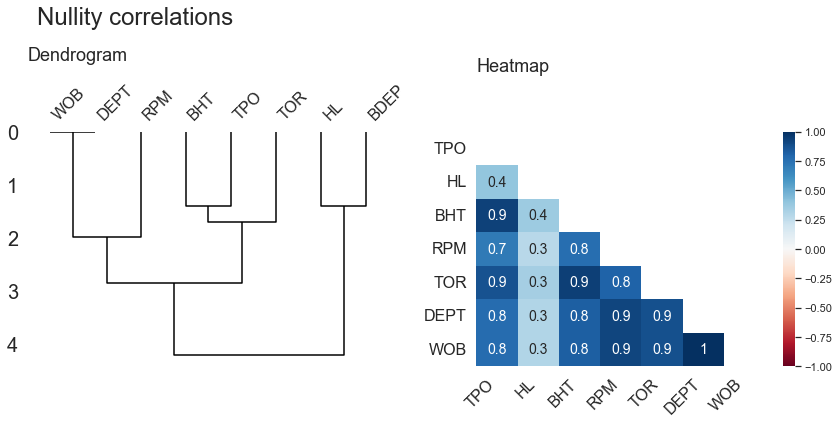

In [192]:
# Plot nullity correlations with dendogram and heatmap
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
msno.dendrogram(data_df, ax=ax[0])
msno.heatmap(data_df, ax=ax[1])
fig.suptitle('Nullity correlations', size=24, horizontalalignment='left', x=0.05)
ax[0].set_title('Dendrogram', size=18, pad=20, loc='left')
ax[1].set_title('Heatmap', size=18, pad=60, loc='left')
plt.tight_layout()
plt.show()

In [199]:
print(f'{CYAN}Total percentage of missing values in the dataset:{WHITE}')
print(f'{data_df.isna().sum().sum() / data_df.size * 100:.2f}%')

Total percentage of missing values in the dataset:
0.04%


Missing values represents just a total of 0.04% in the data, such small amount make it without a relationship with the features. It's more likely they are related to noise in the sensors.  
The solution for this problem will be simply removing all observations with missing data.

## Data clean up

In summary, the following steps were covered in the exploratory data analysis:  
- Load data from csv;
- Cast timestamp values to *datetime* and set as index;
- Drop unimportant columns;
- Merge data frame with annotation data;
- Fill NaNs values, produced by the merge, for the target *Annotation*;
- Drop the remaining NaNs values for all dataset.

In [2]:
# Data cleanup function
def data_cleanup(data:pd.DataFrame, annot:pd.DataFrame) -> pd.DataFrame:
    
    # Cast timestamp value to datetime
    data['datetime'] = pd.to_datetime(data['Unnamed: 0'].apply(lambda x: int(x)), unit='ms')
    annot['datetime'] = pd.to_datetime(annot['Unnamed: 0'], unit='ms')

    # Remove unimportant columns
    data.drop(columns=['Unnamed: 0', 'RPM', 'TOR', 'DEPT'], inplace=True)
    annot.drop(columns=['Unnamed: 0'], inplace=True)

    # Set datetime as index
    data.set_index('datetime', inplace=True)
    annot.set_index('datetime', inplace=True)

    # Merge dataframe on index
    merged_df = data.merge(annot, left_index=True, right_index=True, how='outer')

    # Fill NaN values
    merged_df['Annotation'].fillna(method='ffill', inplace=True)
    merged_df['Annotation'].fillna(method='bfill', inplace=True)

    # Drop the remaining NaN values
    merged_df.dropna(inplace=True)

    return merged_df

# Feature Engineering

Feature engineering is the process of selecting, creating, and transforming variables ito improve the performance of a machine learning model.  

For the time series data, the following features will be created:
- Rolling mean and standard deviation of 6 minutes
- Velocity, also know as lag, the feature shifted by one observation;
- Acceleration, the shift of velocity, captures more abrupts variations.

Using `sklearn` we can create a transformer class to easly apply the transformation inside a pipeline.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create feature engineering class
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        # Using df copy to avoid bugs with pandas loc
        df = X.copy()

        # Create features
        for feature in df.columns:
            # Rolling mean of 2min
            df[f'{feature}_rolling_mean_2min'] = df[feature].rolling('2min').mean()
            # Rollind standard deviation of 2min
            df[f'{feature}_rolling_std_2min'] = df[feature].rolling('2min').std()
            # Velocity
            df[f'{feature}_velocity'] = df[feature].diff()
            # Acceleration
            df[f'{feature}_acceleration'] = df[f'{feature}_velocity'].diff()

        # Trigonometric features for minutes
        # X['minutes'] = X.index.minute + X.index.second/60 + X.index.microsecond/3600000
        # X['minutes_sin'] = np.sin(X['minutes']*(2.*np.pi/60))
        # X['minutes_cos'] = np.cos(X['minutes']*(2.*np.pi/60))

        return df

# Modeling

## Preprocess data

### Define X and y

The first step is to select our features in the *X* data, and the target in the *y*.  
Target values must be encoded in order to be readable by the model.  

In [81]:
# Read data frame and annotations
data_df = pd.read_csv('data/challenge_data.csv')
annot_df = pd.read_csv('data/challenge_annotation.csv')

# Clean data
df = data_cleanup(data_df, annot_df)

# Define X and y
X = df.drop(columns='Annotation')
y = df['Annotation']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### Time series split

`sklearn` Time Series cross validatior provides train/test indices to split time series data samples that are observed at fixed time intervals. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.  

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.  

In [6]:
# Create time series cross-validator and apply split
from sklearn.model_selection import TimeSeriesSplit

# Instantiate time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

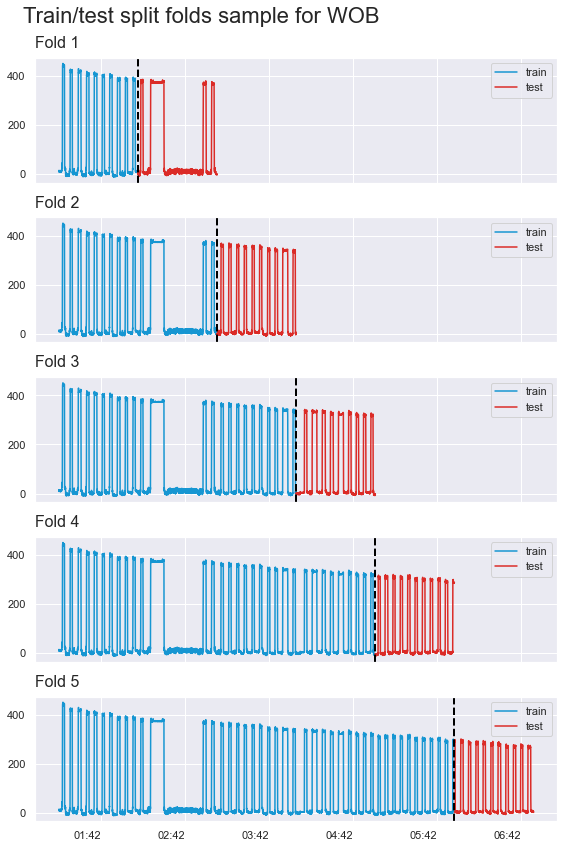

In [82]:
# Applying train/test split and plot results for each fold with WOB feature
fig, ax = plt.subplots(5, 1, figsize=(8, 12), sharex=True, sharey=True)
fig.suptitle('Train/test split folds sample for WOB', size=22, horizontalalignment='left', x=0.05)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    
    # Apply train/test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Plot train/test split sample
    X.iloc[train_index].plot(y='WOB', ax=ax[i], color='#1696d2', label='train')
    X.iloc[test_index].plot(y='WOB', ax=ax[i], color='#db2b27', label='test')
    
    # Add line when test set starts
    ax[i].axvline(X.iloc[test_index].index[0], color='black', linestyle='--', linewidth=2)
    
    # Set title and labels
    ax[i].set_title(f'Fold {i + 1}', size=16, pad=10, loc='left')
    ax[i].set_xlabel('')
    ax[i].legend(loc='upper right')
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i].xaxis.set_major_locator(mdates.MinuteLocator(interval=(i+1) * 12))
    ax[i].tick_params(axis='x', labelrotation=0)

# Show figure
plt.tight_layout()
plt.show()

In [14]:
# Datasets size summary
print(f'{CYAN}Train dataset size:{WHITE} {X_train.shape}')
print(f'{CYAN}Test dataset size:{WHITE} {X_test.shape}')
print(f'{CYAN}Features:{WHITE} {X_train.columns.tolist()}')
print(f'{CYAN}Labels:{WHITE} {le.classes_}')

# Set feature names and labels
FEATURE_NAMES = X_train.columns.tolist()
LABELS = le.classes_

Train dataset size: (33876, 5)
Test dataset size: (6775, 5)
Features: ['BDEP', 'TPO', 'HL', 'BHT', 'WOB']
Labels: ['off_slips' 'on_slips']


### Create preprocess pipeline

Pipeline is a useful tool from `sklearn` to build and apply a list of transformer with the estimator.  
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.  
Using pipelines makes the workflow scalable and avoid data lakage when transforming the data.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [15]:
# Pipelines creation

# Note: despite the data abstention of categorical features,
# some lines will contain the necessary steps to process this data type, 
# making easy to scale the workflow if any categorical feature is added 
# to the dataset in the future

# Select feature types
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
#categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Create piepline for numeric features
numeric_features_pipeline = Pipeline([
    ('std', StandardScaler()),
    ('impute_num', SimpleImputer(strategy='mean')),
])

# Create pipeline for categorical features
# categorical_features_pipeline = Pipeline([
#     ('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# Create preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('numeric_transformer', numeric_features_pipeline, numeric_features),
    #('categorical_transformer', categorical_features_pipeline ,categorical_features)
])

## Baseline model

Baseline models have their importance in providing a point of reference for evaluating the performance of more advanced models. They may be effective but is more used as a benchmark.  
Without a baseline model, it can be difficult to determine whether a more complex model is truly improving the accuracy of predictions or if it is simply overfitting to the data.  

The choice for this first model will be from `sklearn` *Random Forest Classifier*.

### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create pipeline
rf_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('preprocessing', preprocessing_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Apply cross validation
cv_scores = cross_val_score(rf_pipeline, X, y, cv=tscv, scoring='f1_macro')

# Print results
print(f'{CYAN}Cross validation scores:{WHITE} {cv_scores}')
print(f'{CYAN}Mean cross validation score:{WHITE} {np.mean(cv_scores):.4f}')

# Fit model
rf_pipeline.fit(X_train, y_train)

# Predict train/test datasets
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

Cross validation scores: [0.99516342 0.9870556  0.99302847 0.99140852 0.98677938]
Mean cross validation score: 0.9907


### Model evaluation

All metrics will be analyzed in both train and data datasets, to verify if the model is overfitted.  

In [19]:
from sklearn.metrics import classification_report

# Print classification report
print(f'{CYAN}Train dataset\n{WHITE} {classification_report(y_train, y_train_pred)}')
print(f'{CYAN}Test dataset\n{WHITE} {classification_report(y_test, y_test_pred)}')

Train dataset
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23095
           1       1.00      1.00      1.00     10781

    accuracy                           1.00     33876
   macro avg       1.00      1.00      1.00     33876
weighted avg       1.00      1.00      1.00     33876

Test dataset
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4676
           1       0.97      0.99      0.98      2099

    accuracy                           0.99      6775
   macro avg       0.98      0.99      0.99      6775
weighted avg       0.99      0.99      0.99      6775



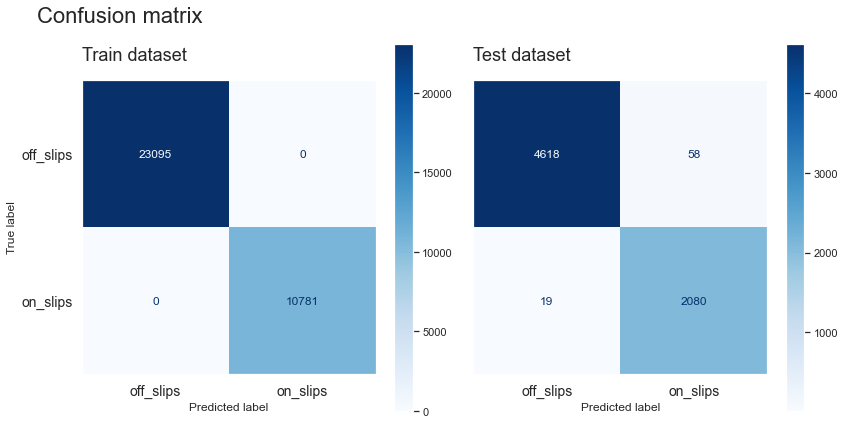

In [20]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Instantiate confusion matrix for train and test datasets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
# Plot confusion matrix for train dataset
fig.suptitle('Confusion matrix', size=22, horizontalalignment='left', x=0.05)
ConfusionMatrixDisplay(cm_train, display_labels=LABELS).plot(ax=ax[0], cmap='Blues')

# Plot confusion matrix for test dataset
ConfusionMatrixDisplay(cm_test, display_labels=LABELS).plot(ax=ax[1], cmap='Blues')

# Style params
for i in range(2):    
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].grid(False)
ax[0].set_title('Train dataset', size=18, pad=20, loc='left')
ax[1].set_title('Test dataset', size=18, pad=20, loc='left')
ax[1].set_ylabel('')

# Show figure
plt.tight_layout()
plt.show()


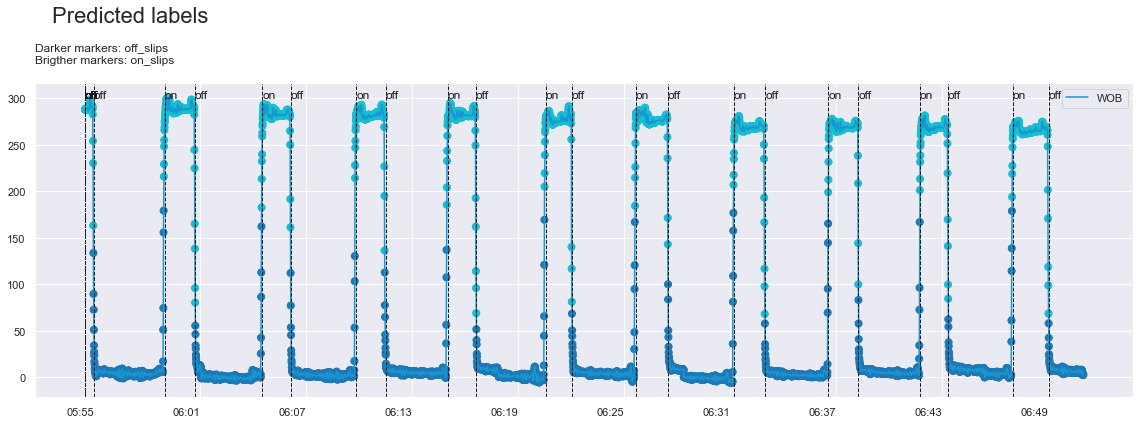

In [ ]:
# Plot X_test time series with color on predicted labels
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
fig.suptitle('Predicted labels', size=22, horizontalalignment='left', x=0.05)
X_test.plot(y='WOB', ax=ax, color='#1696d2', label='WOB')
ax.scatter(X_test.index, X_test['WOB'], c=y_test_pred, cmap='tab10', s=50, label='Predicted labels')
# add Annotation values from annot_df in vertical lines
for i in range(len(annot_df)):
    _index = X_test.index.get_loc(annot_df.index[i], method='nearest')
    ax.axvline(x=X_test.index[_index], color='k', linestyle='--', linewidth=1)
    ax.text(
        X_test.index[_index], 300, annot_df['Annotation'][i].split('_')[0], 
        size=12, color='k')


ax.set_xlabel('')
ax.set_title('Darker markers: off_slips\nBrigther markers: on_slips', size=12, pad=20, loc='left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=6))
ax.tick_params(axis='x', labelrotation=0)

# Show figure
plt.tight_layout()
plt.show()

The baseline model appears to have decorated the training dataset, i.e. overfitting, and still was able to make a very high score on the testing data.  
Scores likes these are suspicious and we can't assume that our model it's perfect. First we need to train on future values, or emulate with a new dataset, preferably with noises and outliers.  

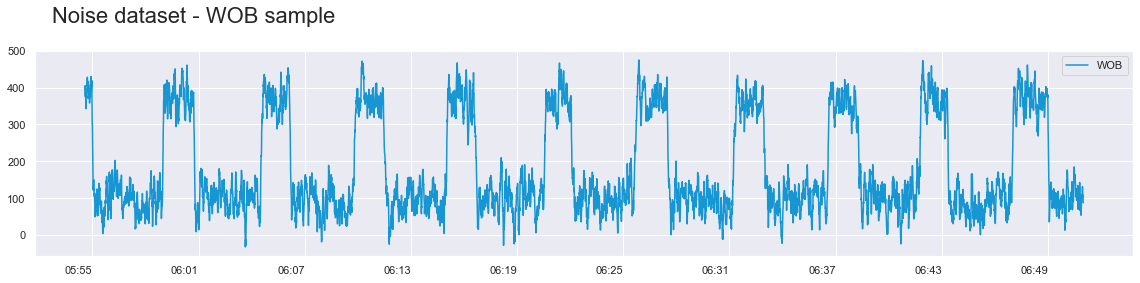

In [21]:
# Gerenate a new dataset with random noise for all features
X_noise = X_test.copy()
for col in X_noise.columns:
    # Add random noise
    X_noise[col] = X_noise[col] + np.random.normal(X_noise[col].mean(), X_noise[col].std(), X_noise.shape[0])
    # Smoothing the values with rolling mean
    X_noise[col] = X_noise[col].rolling(10).mean()

# Visualize the new dataset
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
fig.suptitle('Noise dataset - WOB sample', size=22, horizontalalignment='left', x=0.05)
X_noise.plot(y='WOB', ax=ax, color='#1696d2', label='WOB')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=6))
ax.tick_params(axis='x', labelrotation=0)

# Show figure
plt.tight_layout()
plt.show()

In [22]:
# Test our model in the new dataset
y_noise_pred = rf_pipeline.predict(X_noise)

# Classification report for the new prediction
print(f'{CYAN}Classification report for Noise dataset\n{WHITE} {classification_report(y_test, y_noise_pred)}')

Classification report for Noise dataset
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      4676
           1       0.99      0.36      0.53      2099

    accuracy                           0.80      6775
   macro avg       0.89      0.68      0.70      6775
weighted avg       0.84      0.80      0.77      6775



Adding noise to the data had significant impact on the predictions. This is a warning that the model may have poor performance when different outliers emerge.  

## Improve model with Feature Engineering

After creating the baseline, it's a good pratice test a new model with the created features.  
However, it's more suitable to select a different model to fit the data. 

For now, let's just test the model with feature engineering in the noise dataset to see if the model have bad performance too.

In [23]:
# Feature engineering Pipeline
# Create and fit feature engineering pipeline
feature_engineering_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
]).fit(X_train, y_train)

# # Transform features
X_train_transf = feature_engineering_pipeline.transform(X_train)
X_test_transf = feature_engineering_pipeline.transform(X_test)

In [24]:
# Fit model with transformed features
rf_pipeline.fit(X_train_transf, y_train)

# Model score
print(f'{CYAN}Train dataset score:{WHITE} {rf_pipeline.score(X_train_transf, y_train):.2f}')
print(f'{CYAN}Test dataset score:{WHITE} {rf_pipeline.score(X_test_transf, y_test):.2f}')

Train dataset score: 1.00
Test dataset score: 0.99


In [25]:
# Create the noise dataset
X_noise = X_test_transf.copy()

# Add random noise
for col in X_noise.columns:
    X_noise[col] = X_noise[col] + np.random.normal(X_noise[col].mean(), X_noise[col].std(), X_noise.shape[0])
    X_noise[col] = X_noise[col].rolling(10).mean()

# Predict labels
y_noise_pred = rf_pipeline.predict(X_noise)

# Classification report for the new prediction
print(f'{CYAN}Classification report for Noise dataset\n{WHITE} {classification_report(y_test, y_noise_pred)}')

Classification report for Noise dataset
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      4676
           1       0.99      0.35      0.51      2099

    accuracy                           0.80      6775
   macro avg       0.88      0.67      0.69      6775
weighted avg       0.84      0.80      0.76      6775



Indeed, even adding the new features, there was no change when introducing the noises.

## XGBoost Classifier

In [390]:
# Read data frame and annotations
data_df = pd.read_csv('data/challenge_data.csv')
annot_df = pd.read_csv('data/challenge_annotation.csv')
# Clean data
df = data_cleanup(data_df, annot_df)
# Define X and y
X = df.drop(columns='Annotation')
y = df['Annotation']
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
# Split with time series
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
# Apply feature engineering
fe = FeatureEngineering()
X_train = fe.fit_transform(X_train)
X_test = fe.transform(X_test)
features_names = X_train.columns
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Impute missing values
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

In [380]:
from xgboost import XGBClassifier as xgbc

# Create XGBoost model
xgb_model = xgbc(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    early_stopping_rounds=25,
    eval_metric=['logloss', 'error'],
    random_state=42,
)

# Fit model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10,
)

[0]	validation_0-logloss:0.59945	validation_0-error:0.00425	validation_1-logloss:0.60077	validation_1-error:0.01387
[10]	validation_0-logloss:0.18336	validation_0-error:0.00283	validation_1-logloss:0.19176	validation_1-error:0.01196
[20]	validation_0-logloss:0.06815	validation_0-error:0.00213	validation_1-logloss:0.08068	validation_1-error:0.01063
[30]	validation_0-logloss:0.02865	validation_0-error:0.00168	validation_1-logloss:0.04355	validation_1-error:0.01077
[40]	validation_0-logloss:0.01436	validation_0-error:0.00151	validation_1-logloss:0.03079	validation_1-error:0.01048
[50]	validation_0-logloss:0.00897	validation_0-error:0.00136	validation_1-logloss:0.02608	validation_1-error:0.01018
[60]	validation_0-logloss:0.00684	validation_0-error:0.00127	validation_1-logloss:0.02490	validation_1-error:0.00974
[70]	validation_0-logloss:0.00590	validation_0-error:0.00112	validation_1-logloss:0.02552	validation_1-error:0.01033
[80]	validation_0-logloss:0.00529	validation_0-error:0.00106	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=25,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

### Model evaluation

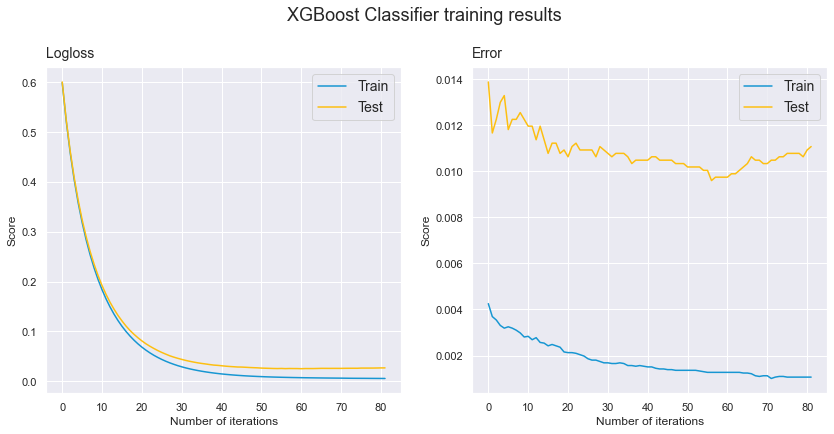

In [381]:
# Plot xgboost model training results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1,2, figsize=(14, 6))
fig.suptitle('XGBoost Classifier training results', size=18, y=1.02)
for i, metric in enumerate(['logloss', 'error']):
    sns.lineplot(
        x=x_axis, y=results['validation_0'][metric], label='Train', 
        ax=ax[i], color=CATEGORICAL_GROUPS[2][0 if i==1 else i])
    sns.lineplot(
        x=x_axis, y=results['validation_1'][metric], label='Test', 
        ax=ax[i], color=CATEGORICAL_GROUPS[2][i+1 if i==0 else i])
    ax[i].set_title(f'{metric.capitalize()}', size=14, pad=10, loc='left')
    ax[i].set_xlabel('Number of iterations')
    ax[i].set_ylabel('Score')
    ax[i].legend(prop={'size': 14})
plt.show()

In [382]:
# Predict on train and test dataset
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

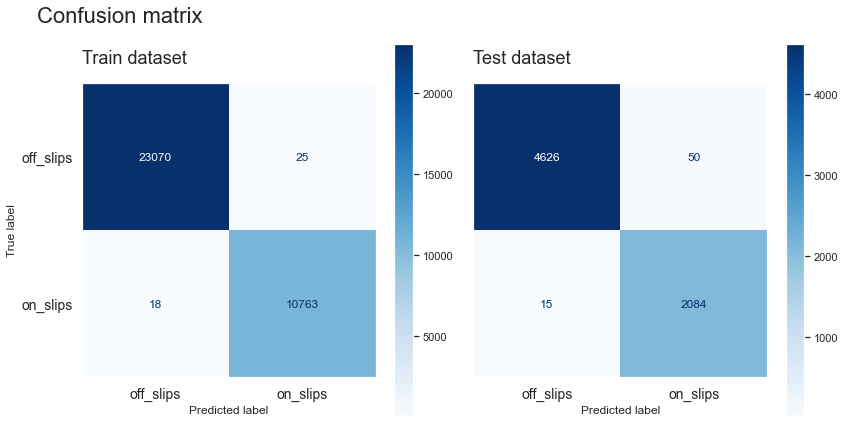

In [383]:
# Instantiate confusion matrix for train and test datasets
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
# Plot confusion matrix for train dataset
fig.suptitle('Confusion matrix', size=22, horizontalalignment='left', x=0.05)
ConfusionMatrixDisplay(cm_train, display_labels=LABELS).plot(ax=ax[0], cmap='Blues')

# Plot confusion matrix for test dataset
ConfusionMatrixDisplay(cm_test, display_labels=LABELS).plot(ax=ax[1], cmap='Blues')

# Style params
for i in range(2):    
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].grid(False)
ax[0].set_title('Train dataset', size=18, pad=20, loc='left')
ax[1].set_title('Test dataset', size=18, pad=20, loc='left')
ax[1].set_ylabel('')

# Show figure
plt.tight_layout()
plt.show()

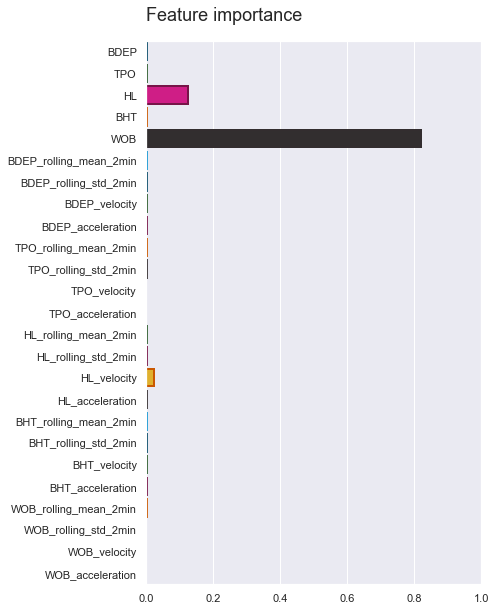

In [394]:
#Plot feature importance
plt.figure(figsize=(6,10))
_data = xgb_model.feature_importances_
sns.barplot(
    x=_data, 
    y=features_names,
    palette=CATEGORICAL_GROUPS[6 if len(_data) > 6 else len(_data)],
    linewidth=2, 
    edgecolor=CATEGORICAL_GROUPS_BAR_EDGE[6 if len(_data) > 6 else len(_data)],
)
plt.title('Feature importance', size=18, pad=20, loc='left')
plt.xlim(0, 1)
plt.show()

del _data

### Predicting future values

In [395]:
# Apply transformations to the whole dataset
X = fe.fit_transform(X)
X = scaler.transform(X)
X = imp.transform(X)
X.shape, y.shape

((40651, 25), (40651,))

In [396]:
# Retrain on all dataset
xgb_model.fit(
    X, y,
    eval_set=[(X, y)],
    verbose=100
)

[0]	validation_0-logloss:0.59968	validation_0-error:0.00509
[100]	validation_0-logloss:0.00459	validation_0-error:0.00071
[200]	validation_0-logloss:0.00184	validation_0-error:0.00002
[206]	validation_0-logloss:0.00174	validation_0-error:0.00002


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=25,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [397]:
# Function to generate time series
def generate_time_series(
    start_time, 
    end_time, 
    low_value, 
    high_value,
    center,
    freq='500L'
    ):

    # Define index
    time_index = pd.date_range(start=start_time, end=end_time, freq=freq)

    # Define the values for each interval
    current_value = low_value.copy()

    # Empty list to store the values for each time step
    _data = []

    # Loop over each second in the time index
    RANDOM_INTERVAL = np.random.randint(90, 240)
    for i in range(len(time_index)):

        # Check if interval changed
        if (i+1) % RANDOM_INTERVAL == 0:

            # Toggle the values between the low and high values
            if current_value < center:
                current_value = high_value.copy()
            else:
                current_value = low_value.copy()

            # Set random interval again
            RANDOM_INTERVAL = np.random.randint(90, 240)

        # Add noise to current value and extend data list
        current_value += np.random.normal(0, 1, len(current_value))
        _data.extend(current_value)

    return _data

In [436]:
_df = df.drop(columns=['Annotation']).copy()
# feat eng in df
_df = fe.fit_transform(_df)
print(f'{CYAN}Last timestamp in data: {WHITE} {_df.index[-1]}')

# Create X_future dataset of 1 hour in half seconds intervals
X_future = pd.DataFrame(
    index=pd.date_range(
        start=_df.index[-1],
        end=_df.index[-1] + pd.Timedelta(minutes=10),
        freq='500L',
    ),
    columns=_df.columns,
)

# Use generate_time_series to fill X_future with values from X
for col in _df.columns:
    X_future[col] = generate_time_series(
        start_time=_df.index[-1] + pd.Timedelta(milliseconds=500),
        end_time=_df.index[-1] + pd.Timedelta(minutes=10) + pd.Timedelta(milliseconds=500),
        low_value=np.random.normal(_df[col].quantile(0.25), _df[col].std()/100, 1),
        high_value=np.random.normal(_df[col].quantile(0.75), _df[col].std()/100, 1),
        center=_df[col].mean(),
    )

# Predict X_future values
y_pred_future = xgb_model.predict(X_future)

# Classification report
print(f'{CYAN}Classification report\n{WHITE} {classification_report(y[-X_future.shape[0]:], y_pred_future)}')

# Concat X_future with X
X_future['future_flag'] = True
_df['future_flag'] = False
X_future = pd.concat([_df, X_future])
X_future.dropna(inplace=True)
X_future = X_future[~X_future.index.duplicated(keep='first')]
_df.drop(columns=['future_flag'], inplace=True)

Last timestamp in data:  2020-12-05 06:50:59.636000
Classification report
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       767
           1       0.61      0.09      0.16       434

    accuracy                           0.65      1201
   macro avg       0.63      0.53      0.47      1201
weighted avg       0.64      0.65      0.56      1201



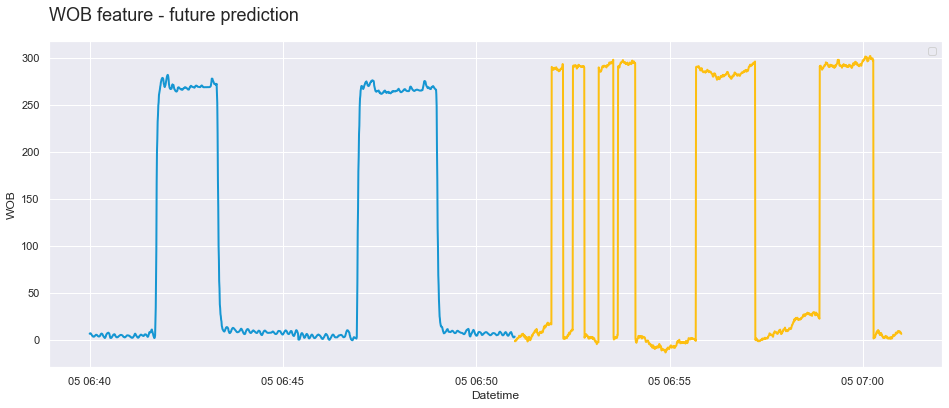

In [454]:
# Plot WOB feature from X_future with hue on future_flag
X_future['datetime'] = X_future.index
plt.figure(figsize=(16,6))
sns.lineplot(
    data=X_future.loc['2020-12-05 06:40:00':],
    x='datetime',
    y='WOB',
    hue='future_flag',
    palette=CATEGORICAL_GROUPS[2],
    linewidth=2,
)
plt.title('WOB feature - future prediction', size=18, pad=20, loc='left')
plt.xlabel('Datetime')
plt.ylabel('WOB')
plt.legend('')
plt.show()

X_future.drop(columns=['datetime'], inplace=True)

## LSTM neural network

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, InputLayer
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [34]:
# Read data frame and annotations
data_df = pd.read_csv('data/challenge_data.csv')
annot_df = pd.read_csv('data/challenge_annotation.csv')

# Clean data
df = data_cleanup(data_df, annot_df)

# Define X and y
X = df.drop(columns='Annotation')
y = df['Annotation']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split 80% train and 20% test with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Show train and test size in percent
print(f'{GREEN}Train size{WHITE}: {len(X_train)} | {len(X_train)/len(X)*100:.2f} %')
print(f'{CYAN}Test size{WHITE}: {len(X_test)} | {len(X_test)/len(X)*100:.2f} %')

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Train size: 33876 | 83.33 %
Test size: 6775 | 16.67 %


((33876, 5, 1), (6775, 5, 1), (33876,), (6775,))

### Build model and fit

In [37]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1, 'sigmoid'))
model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(learning_rate=1e-3)
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Fit model
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/100
1059/1059 [==============================] - 11s 7ms/step - loss: 0.0533 - accuracy: 0.9867 - val_loss: 0.0267 - val_accuracy: 0.9908
Epoch 2/100
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.0350 - val_accuracy: 0.9901
Epoch 3/100
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0299 - val_accuracy: 0.9900
Epoch 4/100
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0204 - accuracy: 0.9935 - val_loss: 0.0365 - val_accuracy: 0.9897
Epoch 5/100
1059/1059 [==============================] - 6s 6ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 6/100
1059/1059 [==============================] - 7s 7ms/step - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.0464 - val_accuracy: 0.9891
Epoch 7/100
1059/1059 [==============================] - 7s 6ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0388 - val_a

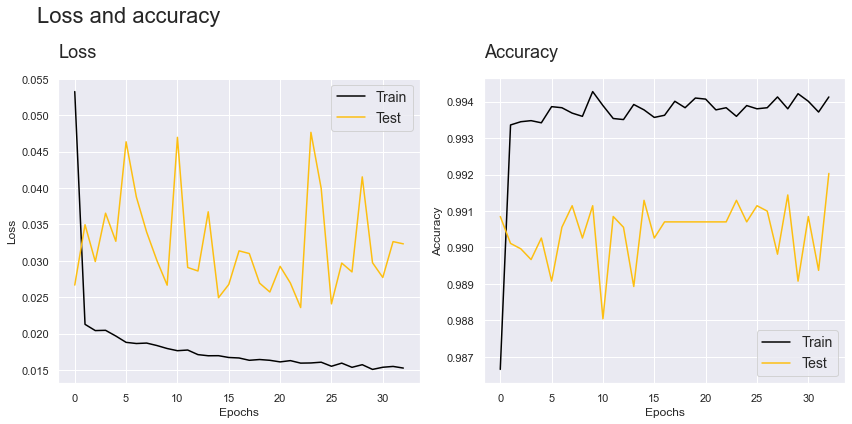

In [49]:
# Plot loss and accuracy in subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Loss and accuracy', size=22, horizontalalignment='left', x=0.05)
sns.lineplot(data=history.history['loss'], ax=ax[0], label='Train', color='#000000')
sns.lineplot(data=history.history['val_loss'], ax=ax[0], label='Test',  color='#fdbf11')
ax[0].set_title('Loss', size=18, pad=20, loc='left')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(prop={'size': 14})
sns.lineplot(data=history.history['accuracy'], ax=ax[1], label='Train', color='#000000')
sns.lineplot(data=history.history['val_accuracy'], ax=ax[1], label='Test', color='#fdbf11')
ax[1].set_title('Accuracy', size=18, pad=20, loc='left')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(prop={'size': 14})
plt.tight_layout()
plt.show()

In [50]:
# Make predicitons for train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

212/212 [==============================] - 1s 3ms/step


### Metrics for LSTM

In [51]:
# Classification report
print(f'{GREEN}Train classification report{WHITE}:')
print(classification_report(y_train, y_train_pred.round(), target_names=LABELS, digits=3, zero_division=0))
print(f'{CYAN}Test classification report{WHITE}:')
print(classification_report(y_test, y_test_pred.round(), target_names=LABELS, digits=3, zero_division=0))


Train classification report:
              precision    recall  f1-score   support

   off_slips      0.996     0.995     0.996     23095
    on_slips      0.990     0.991     0.990     10781

    accuracy                          0.994     33876
   macro avg      0.993     0.993     0.993     33876
weighted avg      0.994     0.994     0.994     33876

Test classification report:
              precision    recall  f1-score   support

   off_slips      0.995     0.992     0.993      4676
    on_slips      0.982     0.989     0.985      2099

    accuracy                          0.991      6775
   macro avg      0.988     0.990     0.989      6775
weighted avg      0.991     0.991     0.991      6775



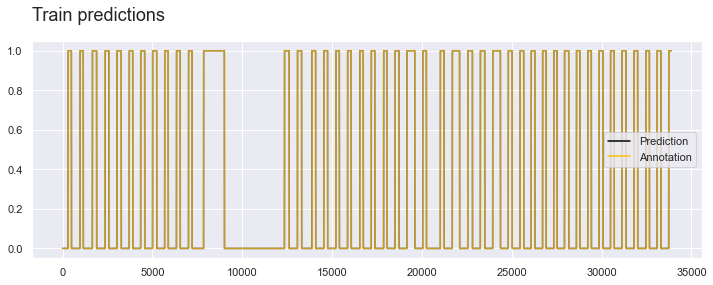

In [52]:
# Plot predictions
plt.figure(figsize=(12, 4))
sns.lineplot(data=pd.DataFrame(y_train_pred.round(), columns=['Prediction']), ci=None, dashes=False, palette=['#000000'], alpha=0.7)
sns.lineplot(data=pd.DataFrame(y_train, columns=['Annotation']), ci=None, dashes=False, palette=['#fdbf11'], alpha=0.7)
plt.title('Train predictions', fontsize=18, pad=20, loc='left')
plt.show()


In [455]:
import session_info

session_info.show()